In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import sys
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v6 import Autoencoder
from tools.GRU_SingleStep_v10 import RNN_GRU

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-01-18 00:28:47.421542: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-18 00:28:47.422175: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-18 00:28:47.474528: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-18 00:28:47.474963: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-18 00:28:47.475258: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # making RNN save directory
    dir_name_rnn = os.getcwd() + dir_sep + 'saved_rnn'
    if not os.path.isdir(dir_name_rnn):
        os.makedirs(dir_name_rnn)

    counter = 0
    while True:
        dir_check = 'rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_rnn = dir_name_rnn + dir_sep + dir_check
    os.makedirs(dir_name_rnn)
    os.makedirs(dir_name_rnn+dir_sep+'plots')

    # whether to use AE data or just work on raw data
    use_ae_data = True # if false, specifying ae_idx will only show which dataset to use

    # autoencoder directory
    ae_idx = '046'
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
else:
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_015'

    # reading AE directory
    with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))

    try:
        use_ae_data = params_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in sim_data_AE_params, set to True.")
        normalize_dataset = True
    
    dir_name_ae = params_dict['dir_name_ae']
    ae_idx = dir_name_ae[-3:]
    dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx

    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    T_sample_input = params_rnn_dict['T_sample_input']
    T_sample_output = params_rnn_dict['T_sample_output']
    T_offset = params_rnn_dict['T_offset']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in RNN_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    try:
        dense_layer_act_func = params_rnn_dict['dense_layer_act_func']
    except:
        print("'dense_layer_act_func' not present in RNN_specific_data, set to 'linear'.")
        dense_layer_act_func = 'linear'
    try:
        stateful = params_rnn_dict['stateful']
    except:
        print("'stateful' not present in RNN_specific_data, set to True.")
        stateful = True
    try:
        use_learnable_state = params_rnn_dict['use_learnable_state']
    except:
        print("'use_learnable_state' not present in RNN_specific_data, set to False.")
        use_learnable_state = False
    try:
        use_weights_post_dense = params_rnn_dict['use_weights_post_dense']
    except:
        print("'use_weights_post_dense' not present in RNN_specific_data, set to False.")
        use_weights_post_dense = False
    try:
        use_ae_data = params_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in RNN_specific_data, set to True.")
        use_ae_data = True

    

    normalization_arr = None
    try:
        with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
            lines = f.readlines()
        rnn_norm_arr_dict = eval(lines)
        normalization_arr = rnn_norm_arr_dict['normalization_arr']
    except:
        pass
    if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
        with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
            normalization_arr = fl['normalization_arr'][0]

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to 'True'.")
    ae_data_with_params = True

if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data']
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_046
data_dir_idx: 005
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [14]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

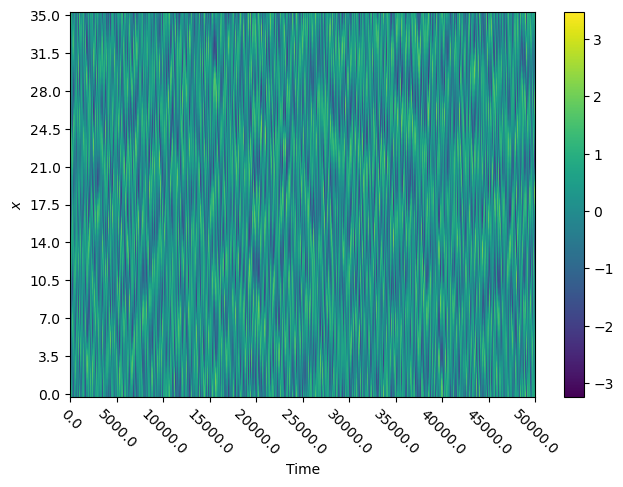

In [15]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [16]:
# dealing with normalizing the data before feeding into autoencoder
if use_ae_data == True:
    if normalizeforae_flag == True:
        for i in range(numpoints_xgrid):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]

    if ae_data_with_params == False:
        all_data = all_data[:, 0:numpoints_xgrid]
else:
    # using raw data, neglecting the params attached (if any)
    all_data = all_data[:, 0:numpoints_xgrid]

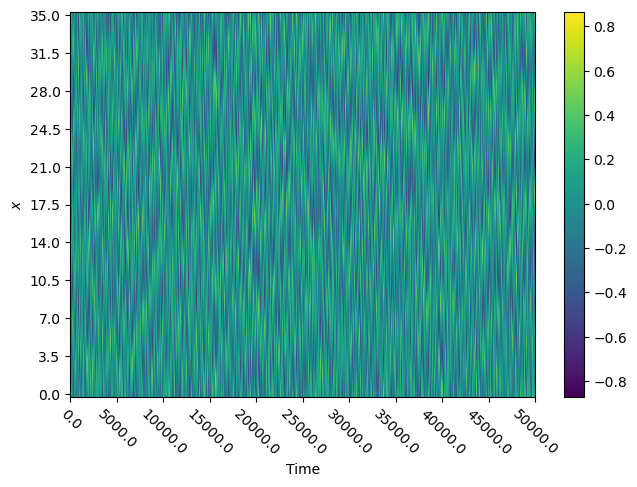

In [17]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

# Autoencoder

In [18]:
if use_ae_data == True:
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [19]:
if use_ae_data == True:
    ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

In [20]:
# create data
if use_ae_data == True:
    latent_states_all = ae_net.encoder_net.predict(all_data)
    del(all_data)
else:
    latent_states_all = all_data
num_latent_states = latent_states_all.shape[1]

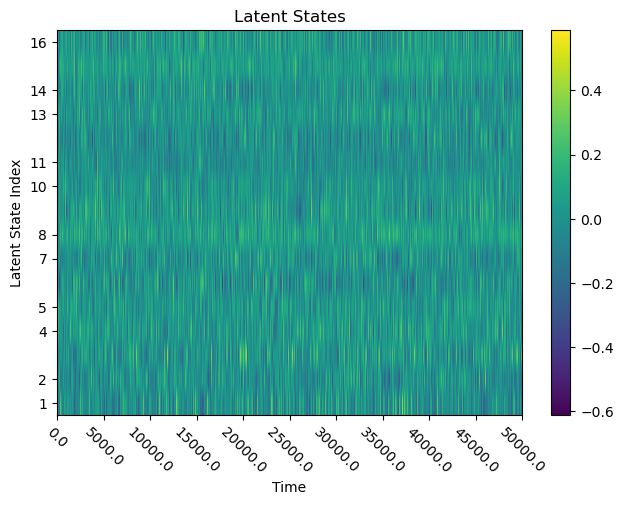

In [21]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=int(40*np.round((T//10)/40)),
    num_yticks=11,
    save_figs=False)

In [22]:
# for i in range(ae_net.layers):
#     tf.keras.utils.plot_model(
#         ae_net.layers[i],
#         to_file=dir_name_ae+'/plots/netlayer_{}.png'.format(i),
#         show_shapes=True,
#         dpi=300
# )

# GRU

In [23]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = 5 # int(5000/np.mean(lyapunov_time_arr))#
    dt_rnn = 0.2
    T_sample_input = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = dt_rnn
    normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
    normalization_arr = None
    skip_intermediate = 'full sample'
    noise_type = 'normal' # can be 'uniform' or 'normal'

    # can be 'minmax', 'minmax2', 'stddev', or a list with
    # sequential order of any of these; if it is 'minmax'
    # then stddev_multiplier has no effect
    normalization_type = 'stddev'
    stddev_multiplier = 3

    dense_layer_act_func = ['tanh']
    use_weights_post_dense = True
    stateful = True
    use_learnable_state = False
    use_trainable_weights_with_reslayers = True
        
    if return_params_arr != False:
        params = params_arr
    else:
        params = None
        
    # timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)

    # saving simulation data
    sim_data = {
        'params_mat':params_mat,
        'init_state_mat':init_state_mat,
        't0':t0,
        'T':T,
        'delta_t':delta_t,
        'return_params_arr':return_params_arr,
        'dir_name_ae':dir_name_ae,
        'normalize_dataset':normalize_dataset,
        'stddev_multiplier':stddev_multiplier,
        'use_ae_data':use_ae_data,
    }


    with open(dir_name_rnn+dir_sep+'sim_data_AE_params.txt', 'w') as f:
        f.write(str(sim_data))
        
    # saving RNN specific data
    RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':RNN_GRU.__module__,
        'noise_type':noise_type,
        'normalization_type':normalization_type,
        'dense_layer_act_func':dense_layer_act_func,
        'stateful':stateful,
        'use_learnable_state':use_learnable_state,
        'use_weights_post_dense':use_weights_post_dense,
        'use_trainable_weights_with_reslayers':use_trainable_weights_with_reslayers,
    }

    with open(dir_name_rnn+dir_sep+'RNN_specific_data.txt', 'w') as f:
        f.write(str(RNN_specific_data))

In [24]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [25]:
temp = np.divide(latent_states_all-normalization_arr[0], normalization_arr[1])
time_stddev = np.std(temp, axis=0)
timeMeanofSpaceRMS = np.mean(np.mean(temp**2, axis=1)**0.5)
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)
del(temp)

In [26]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [1e-3, 1e-4, 1e-5]
    epochs = 1000
    patience = 10 # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 5e-7  # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 64
    fRMS = 2/100
    zoneout_rate = 0.0
    rnncell_dropout_rate = 0.0
    denselayer_dropout_rate = 0.0
    

    stddev = fRMS*timeMeanofSpaceRMS
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
        'stddev':stddev,
        'zoneout_rate':zoneout_rate,
        'rnncell_dropout_rate':rnncell_dropout_rate,
        'denselayer_dropout_rate':denselayer_dropout_rate,
    }

    with open(dir_name_rnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_rnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr],
    )
    
else:
    # dir_name_rnn_og = dir_name_rnn
    # dir_name_rnn_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_rnn/rnn_'+dir_name_rnn_og[-3:]
    # dir_name_rnn = dir_name_rnn_temp

    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()


    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [27]:
# idx = np.arange(data_rnn_input.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round(train_split*data_rnn_input.shape[0]))

# training_data_rnn_input = data_rnn_input[idx[0:boundary]]
# training_data_rnn_output = data_rnn_output[idx[0:boundary]]

# testing_data_rnn_input = data_rnn_input[idx[boundary:]]
# testing_data_rnn_output = data_rnn_output[idx[boundary:]]

In [28]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_val_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_test_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_samples_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
begin_idx = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train_arr[i] = batch_size * (int( (1-test_split-val_split)*num_samples )//batch_size)
    num_val_arr[i] = batch_size * (int(val_split*num_samples)//batch_size)
    num_test_arr[i] = batch_size * int((num_samples - num_train_arr[i] - num_val_arr[i])//batch_size)
    num_samples_arr[i] = num_train_arr[i] + num_val_arr[i] + num_test_arr[i]
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [np.sum(num_train_arr)]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [np.sum(num_train_arr)]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [np.sum(num_val_arr)]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [np.sum(num_val_arr)]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [np.sum(num_test_arr)]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [np.sum(num_test_arr)]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape)
training_data_rnn_output = np.empty(shape=training_output_shape)

val_data_rnn_input = np.empty(shape=val_input_shape)
val_data_rnn_output = np.empty(shape=val_output_shape)

testing_data_rnn_input = np.empty(shape=testing_input_shape)
testing_data_rnn_output = np.empty(shape=testing_output_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    # num_samples = idx.shape[0]
    # num_train = int( (1-test_split-val_split)*num_samples )
    # num_val = int(val_split*num_samples)
    num_samples = num_samples_arr[i]
    num_train = num_train_arr[i]
    num_val = num_val_arr[i]
    num_test = num_test_arr[i]
    
    nbatches_train = num_train // batch_size
    nbatches_val = num_val // batch_size
    nbatches_test = num_test // batch_size

    for j in range(batch_size):
        training_data_rnn_input[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_input[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        training_data_rnn_output[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_output[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        
        val_data_rnn_input[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_input[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]
        val_data_rnn_output[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_output[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]

        testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_input[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]
        testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_output[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]


    # training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    # training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    # val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    # val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    # num_test = num_samples-num_train-num_val+1
    # testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    # testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)

# further shuffling
if stateful == False:
    idx = np.arange(0, training_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    training_data_rnn_input = training_data_rnn_input[idx]
    training_data_rnn_output = training_data_rnn_output[idx]

    idx = np.arange(0, val_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    val_data_rnn_input = val_data_rnn_input[idx]
    val_data_rnn_output = val_data_rnn_output[idx]

    idx = np.arange(0, testing_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    testing_data_rnn_input = testing_data_rnn_input[idx]
    testing_data_rnn_output = testing_data_rnn_output[idx]

    del(idx)

In [29]:
print('training_data_rnn_input.shape : ', training_data_rnn_input.shape)
print(' testing_data_rnn_input.shape : ', testing_data_rnn_input.shape)
print('     val_data_rnn_input.shape : ', val_data_rnn_input.shape)

training_data_rnn_input.shape :  (512, 387, 16)
 testing_data_rnn_input.shape :  (64, 387, 16)
     val_data_rnn_input.shape :  (64, 387, 16)


In [30]:
# print(rnn_data_boundary_idx_arr)

In [31]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    rnn_layers_units = [500]*3
    scalar_weights = None
    # scalar_weights = [
    #     0.5, 
    #     0.0, 0.5,
    #     0.0, 0.0, 1.0,
    #     1/6, 1/3, 1/3, 1/6
    # ] # RK4
    # scalar_weights = [
    #     1.0,
    #     0.25, 0.25,
    #     1/6, 1/6, 2/3
    # ] # TVD RK3
    # scalar_weights = [
    #     1.0,
    #     0.5, 0.5
    # ] # TVD RK2
    # rnn_layers_units = [500]*int(1 + ((8*len(scalar_weights)+1)**0.5 - 1)/2)
    # timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)
    print('timeMeanofSpaceRMS :', timeMeanofSpaceRMS)
    print('stddev :', stddev)
    if return_params_arr != False:
        data_dim = num_latent_states + 3
    else:
        data_dim = num_latent_states

    dense_dim = [rnn_layers_units[-1]]*(len(dense_layer_act_func)-1)
    dense_dim.append(data_dim)
        
    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                data_dim=data_dim,
            #     in_steps=int(T_sample_input // dt_rnn),
            #     out_steps=int(T_sample_output // dt_rnn),
                dt_rnn=dt_rnn,
                lambda_reg=lambda_reg,
                reg_name='L2',
                rnn_layers_units=rnn_layers_units,
                dense_layer_act_func=dense_layer_act_func,
                load_file=None,
                # T_input=T_sample_input,
                # T_output=T_sample_output,
                stddev=stddev,
                noise_type=noise_type,
                dense_dim=dense_dim,
                use_learnable_state=use_learnable_state,
                stateful=stateful,
                zoneout_rate=zoneout_rate,
                batch_size=batch_size,
                use_weights_post_dense=use_weights_post_dense,
                rnncell_dropout_rate=rnncell_dropout_rate,
                denselayer_dropout_rate=denselayer_dropout_rate,
                scalar_weights=scalar_weights, # corresponding to RK4
                use_trainable_weights_with_reslayers=use_trainable_weights_with_reslayers,
            )
    else:
        rnn_net = RNN_GRU(
            data_dim=data_dim,
        #     in_steps=int(T_sample_input // dt_rnn),
        #     out_steps=int(T_sample_output // dt_rnn),
            dt_rnn=dt_rnn,
            lambda_reg=lambda_reg,
            reg_name='L2',
            rnn_layers_units=rnn_layers_units,
            dense_layer_act_func=dense_layer_act_func,
            load_file=None,
            # T_input=T_sample_input,
            # T_output=T_sample_output,
            stddev=stddev,
            noise_type=noise_type,
            dense_dim=dense_dim,
            use_learnable_state=use_learnable_state,
            stateful=stateful,
            zoneout_rate=zoneout_rate,
            batch_size=batch_size,
            use_weights_post_dense=use_weights_post_dense,
            rnncell_dropout_rate=rnncell_dropout_rate,
            denselayer_dropout_rate=denselayer_dropout_rate,
            scalar_weights=scalar_weights, # corresponding to RK4
            use_trainable_weights_with_reslayers=use_trainable_weights_with_reslayers,
        )
    save_path = dir_name_rnn+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    rnn_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_rnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                load_file=load_file,
                # T_input=T_sample_input,
                # T_output=T_sample_output,
                batch_size=batch_size,
                
            )
    else:
        rnn_net = RNN_GRU(
            load_file=load_file,
            # T_input=T_sample_input,
            # T_output=T_sample_output,
            batch_size=batch_size
        )

    rnn_net.build(input_shape=(batch_size, None, num_latent_states))
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_rnn+dir_sep+'checkpoints')
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'final_net_gru_weights.h5'
        # wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'f2'#+dir_sep+'saved_model.pb'
        rnn_net.load_weights_from_file(wt_file)
    
    # this forces the model to initialize its kernel weights/biases
    # temp = rnn_net.predict(tf.ones(shape=[batch_size, int(T_sample_input//dt_rnn), rnn_net.data_dim]))
    # this loads just the kernel wieghts and biases of the model
#     rnn_net.load_weights_from_file(wt_file)

    # rnn_net = tf.keras.models.load_model(wt_file)

timeMeanofSpaceRMS : 0.33066237
stddev : 0.006613247394561768


In [32]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
    earlystopping_wait = 0
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt, earlystopping_wait = readAndReturnLossHistories(
        dir_name_ae=dir_name_rnn,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list,
        return_earlystopping_wait=True)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_rnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [33]:
train_NMSE_hist = []
val_NMSE_hist = []

train_MSE_hist = []
val_MSE_hist = []

In [34]:
class NMSE(tf.keras.metrics.MeanSquaredError):
    def __init__(self, divisor_arr, name='NMSE', **kwargs):
        super(NMSE, self).__init__(name, **kwargs)
        self.divisor_arr = divisor_arr

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = y_true / self.divisor_arr
        y_pred = y_pred / self.divisor_arr
        return super(NMSE, self).update_state(y_true, y_pred, sample_weight)

In [35]:
# compiling the network
rnn_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
    metrics=['mse', NMSE(divisor_arr=time_stddev)],
    run_eagerly=False
)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    if strategy is not None:
        with strategy.scope():
            rnn_net.load_weights(wt_file)
    else:
        rnn_net.load_weights(wt_file)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    baseline = None
    if behaviour == 'loadCheckpointAndContinueTraining':
        baseline = np.min(val_loss_hist)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_NMSE',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta,
        baseline=baseline
    )
    #** the two lines below are useless because wait is set to 0 in on_train_begin
    # early_stopping_cb.wait = earlystopping_wait
    # print('early_stopping_cb.wait : {}\n'.format(early_stopping_cb.wait))

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_rnn+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_NMSE',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        initial_value_threshold=baseline,
        period=1  # saves every `period` epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=1)

    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(rnn_net.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = rnn_net.fit(training_data_rnn_input, training_data_rnn_output,
            epochs=EPOCHS,
            batch_size=batch_size,
#             validation_split=val_split/train_split,
            validation_data=(val_data_rnn_input, val_data_rnn_output),
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1,
            shuffle=not stateful,
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        val_NMSE_hist.extend(history.history['val_NMSE'])
        train_NMSE_hist.extend(history.history['NMSE'])

        val_MSE_hist.extend(history.history['val_mse'])
        train_MSE_hist.extend(history.history['mse'])
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
8/8 [==============================] - ETA: 0s - loss: 0.0342 - mse: 0.0335 - NMSE: 0.3012 - tot_time: 0h 0m 18.3s

Epoch 1: val_NMSE improved from inf to 0.10242, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 0.0342 - mse: 0.0335 - NMSE: 0.3012 - val_loss: 0.0122 - val_mse: 0.0114 - val_NMSE: 0.1024
Epoch 2/1000
8/8 [==============================] - ETA: 0s - loss: 0.0090 - mse: 0.0083 - NMSE: 0.0743 - tot_time: 0h 0m 33.3s

Epoch 2: val_NMSE improved from 0.10242 to 0.06364, saving model to /home

8/8 [==============================] - ETA: 0s - loss: 0.0019 - mse: 0.0013 - NMSE: 0.0118 - tot_time: 0h 3m 50.3s

Epoch 15: val_NMSE improved from 0.01487 to 0.01435, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 0.0019 - mse: 0.0013 - NMSE: 0.0118 - val_loss: 0.0022 - val_mse: 0.0016 - val_NMSE: 0.0144
Epoch 16/1000
8/8 [==============================] - ETA: 0s - loss: 0.0019 - mse: 0.0013 - NMSE: 0.0114 - tot_time: 0h 4m 5.7s

Epoch 16: val_NMSE improved from 0.01435 to 0.01392, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - los

Epoch 30/1000
8/8 [==============================] - ETA: 0s - loss: 0.0013 - mse: 9.0226e-04 - NMSE: 0.0081 - tot_time: 0h 7m 34.0s

Epoch 30: val_NMSE improved from 0.01055 to 0.01037, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 0.0013 - mse: 9.0226e-04 - NMSE: 0.0081 - val_loss: 0.0016 - val_mse: 0.0012 - val_NMSE: 0.0104
Epoch 31/1000
8/8 [==============================] - ETA: 0s - loss: 0.0013 - mse: 8.8529e-04 - NMSE: 0.0080 - tot_time: 0h 7m 48.8s

Epoch 31: val_NMSE improved from 0.01037 to 0.01020, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [========================

Epoch 45/1000
8/8 [==============================] - ETA: 0s - loss: 0.0010 - mse: 7.0468e-04 - NMSE: 0.0063 - tot_time: 0h 11m 17.2s

Epoch 45: val_NMSE improved from 0.00846 to 0.00836, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 0.0010 - mse: 7.0468e-04 - NMSE: 0.0063 - val_loss: 0.0013 - val_mse: 9.2872e-04 - val_NMSE: 0.0084
Epoch 46/1000
8/8 [==============================] - ETA: 0s - loss: 0.0010 - mse: 6.9498e-04 - NMSE: 0.0063 - tot_time: 0h 11m 32.0s

Epoch 46: val_NMSE improved from 0.00836 to 0.00825, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==================

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 8.9258e-04 - mse: 5.8882e-04 - NMSE: 0.0053 - val_loss: 0.0011 - val_mse: 7.8573e-04 - val_NMSE: 0.0071
Epoch 60/1000
8/8 [==============================] - ETA: 0s - loss: 8.8386e-04 - mse: 5.8189e-04 - NMSE: 0.0052 - tot_time: 0h 15m 0.2s

Epoch 60: val_NMSE improved from 0.00707 to 0.00700, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 8.8386e-04 - mse: 5.8189e-04 - NMSE: 0.0052 - val_loss: 0.0011 - val_mse: 7.7757e-04 - val_NMSE: 0.0070
Epoch 61/1000
8/8 [==============================] - ETA: 0s - loss: 8.7578e-04 - mse: 5.7551e-04 - NMSE: 0.0052 - tot_time: 0h 15m 14.9s



Epoch 74/1000
8/8 [==============================] - ETA: 0s - loss: 7.9130e-04 - mse: 5.0754e-04 - NMSE: 0.0046 - tot_time: 0h 18m 27.8s

Epoch 74: val_NMSE improved from 0.00627 to 0.00622, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 7.9130e-04 - mse: 5.0754e-04 - NMSE: 0.0046 - val_loss: 9.7396e-04 - val_mse: 6.9075e-04 - val_NMSE: 0.0062
Epoch 75/1000
8/8 [==============================] - ETA: 0s - loss: 7.8610e-04 - mse: 5.0332e-04 - NMSE: 0.0045 - tot_time: 0h 18m 42.6s

Epoch 75: val_NMSE improved from 0.00622 to 0.00617, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==

8/8 [==============================] - ETA: 0s - loss: 7.2546e-04 - mse: 4.5374e-04 - NMSE: 0.0041 - tot_time: 0h 21m 56.3s

Epoch 88: val_NMSE improved from 0.00565 to 0.00561, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 7.2546e-04 - mse: 4.5374e-04 - NMSE: 0.0041 - val_loss: 8.9414e-04 - val_mse: 6.2285e-04 - val_NMSE: 0.0056
Epoch 89/1000
8/8 [==============================] - ETA: 0s - loss: 7.2176e-04 - mse: 4.5080e-04 - NMSE: 0.0041 - tot_time: 0h 22m 11.2s

Epoch 89: val_NMSE improved from 0.00561 to 0.00557, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [================

8/8 [==============================] - ETA: 0s - loss: 6.7252e-04 - mse: 4.1107e-04 - NMSE: 0.0037 - tot_time: 0h 25m 23.4s

Epoch 102: val_NMSE improved from 0.00519 to 0.00516, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 6.7252e-04 - mse: 4.1107e-04 - NMSE: 0.0037 - val_loss: 8.3420e-04 - val_mse: 5.7314e-04 - val_NMSE: 0.0052
Epoch 103/1000
8/8 [==============================] - ETA: 0s - loss: 6.6846e-04 - mse: 4.0772e-04 - NMSE: 0.0037 - tot_time: 0h 25m 38.0s

Epoch 103: val_NMSE improved from 0.00516 to 0.00513, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [=============

8/8 [==============================] - ETA: 0s - loss: 6.3372e-04 - mse: 3.8207e-04 - NMSE: 0.0034 - tot_time: 0h 28m 51.0s

Epoch 116: val_NMSE improved from 0.00480 to 0.00477, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 6.3372e-04 - mse: 3.8207e-04 - NMSE: 0.0034 - val_loss: 7.8173e-04 - val_mse: 5.3047e-04 - val_NMSE: 0.0048
Epoch 117/1000
8/8 [==============================] - ETA: 0s - loss: 6.3090e-04 - mse: 3.7995e-04 - NMSE: 0.0034 - tot_time: 0h 29m 5.8s

Epoch 117: val_NMSE improved from 0.00477 to 0.00476, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============

8/8 [==============================] - ETA: 0s - loss: 5.8963e-04 - mse: 3.4759e-04 - NMSE: 0.0031 - tot_time: 0h 32m 16.9s

Epoch 130: val_NMSE improved from 0.00444 to 0.00440, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 5.8963e-04 - mse: 3.4759e-04 - NMSE: 0.0031 - val_loss: 7.3086e-04 - val_mse: 4.8919e-04 - val_NMSE: 0.0044
Epoch 131/1000
8/8 [==============================] - ETA: 0s - loss: 5.8733e-04 - mse: 3.4597e-04 - NMSE: 0.0031 - tot_time: 0h 32m 31.6s

Epoch 131: val_NMSE improved from 0.00440 to 0.00438, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [=============

8/8 [==============================] - ETA: 0s - loss: 5.5545e-04 - mse: 3.2292e-04 - NMSE: 0.0029 - tot_time: 0h 35m 43.1s

Epoch 144: val_NMSE improved from 0.00413 to 0.00412, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 5.5545e-04 - mse: 3.2292e-04 - NMSE: 0.0029 - val_loss: 6.9002e-04 - val_mse: 4.5787e-04 - val_NMSE: 0.0041
Epoch 145/1000
8/8 [==============================] - ETA: 0s - loss: 5.5371e-04 - mse: 3.2185e-04 - NMSE: 0.0029 - tot_time: 0h 35m 57.8s

Epoch 145: val_NMSE improved from 0.00412 to 0.00410, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [=============

8/8 [==============================] - ETA: 0s - loss: 5.2382e-04 - mse: 3.0068e-04 - NMSE: 0.0027 - tot_time: 0h 39m 10.7s

Epoch 158: val_NMSE improved from 0.00384 to 0.00383, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 5.2382e-04 - mse: 3.0068e-04 - NMSE: 0.0027 - val_loss: 6.4805e-04 - val_mse: 4.2529e-04 - val_NMSE: 0.0038
Epoch 159/1000
8/8 [==============================] - ETA: 0s - loss: 5.2210e-04 - mse: 2.9963e-04 - NMSE: 0.0027 - tot_time: 0h 39m 25.5s

Epoch 159: val_NMSE improved from 0.00383 to 0.00382, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [=============

8/8 [==============================] - ETA: 0s - loss: 4.9543e-04 - mse: 2.8156e-04 - NMSE: 0.0025 - tot_time: 0h 42m 39.0s

Epoch 172: val_NMSE improved from 0.00361 to 0.00360, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 4.9543e-04 - mse: 2.8156e-04 - NMSE: 0.0025 - val_loss: 6.1299e-04 - val_mse: 3.9949e-04 - val_NMSE: 0.0036
Epoch 173/1000
8/8 [==============================] - ETA: 0s - loss: 4.9513e-04 - mse: 2.8192e-04 - NMSE: 0.0025 - tot_time: 0h 42m 53.8s

Epoch 173: val_NMSE improved from 0.00360 to 0.00359, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [=============

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 4.7380e-04 - mse: 2.6905e-04 - NMSE: 0.0024 - val_loss: 5.8484e-04 - val_mse: 3.8046e-04 - val_NMSE: 0.0034
Epoch 187/1000
8/8 [==============================] - ETA: 0s - loss: 4.7059e-04 - mse: 2.6648e-04 - NMSE: 0.0024 - tot_time: 0h 46m 21.1s

Epoch 187: val_NMSE improved from 0.00342 to 0.00341, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 4.7059e-04 - mse: 2.6648e-04 - NMSE: 0.0024 - val_loss: 5.8306e-04 - val_mse: 3.7931e-04 - val_NMSE: 0.0034
Epoch 188/1000
8/8 [==============================] - ETA: 0s - loss: 4.6833e-04 - mse: 2.6487e-04 - NMSE: 0.0024 - tot_time: 0h

Epoch 201/1000
8/8 [==============================] - ETA: 0s - loss: 4.4534e-04 - mse: 2.5012e-04 - NMSE: 0.0023 - tot_time: 0h 49m 48.6s

Epoch 201: val_NMSE improved from 0.00322 to 0.00320, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 4.4534e-04 - mse: 2.5012e-04 - NMSE: 0.0023 - val_loss: 5.5019e-04 - val_mse: 3.5533e-04 - val_NMSE: 0.0032
Epoch 202/1000
8/8 [==============================] - ETA: 0s - loss: 4.4297e-04 - mse: 2.4839e-04 - NMSE: 0.0022 - tot_time: 0h 50m 3.5s

Epoch 202: val_NMSE improved from 0.00320 to 0.00318, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 4.2377e-04 - mse: 2.3722e-04 - NMSE: 0.0021 - val_loss: 5.2280e-04 - val_mse: 3.3660e-04 - val_NMSE: 0.0030
Epoch 216/1000
8/8 [==============================] - ETA: 0s - loss: 4.2255e-04 - mse: 2.3662e-04 - NMSE: 0.0021 - tot_time: 0h 53m 31.7s

Epoch 216: val_NMSE improved from 0.00303 to 0.00301, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 4.2255e-04 - mse: 2.3662e-04 - NMSE: 0.0021 - val_loss: 5.2042e-04 - val_mse: 3.3482e-04 - val_NMSE: 0.0030
Epoch 217/1000
8/8 [==============================] - ETA: 0s - loss: 4.2127e-04 - mse: 2.3594e-04 - NMSE: 0.0021 - tot_time: 0h

Epoch 231/1000
8/8 [==============================] - ETA: 0s - loss: 3.9891e-04 - mse: 2.2189e-04 - NMSE: 0.0020 - tot_time: 0h 57m 11.2s

Epoch 231: val_NMSE did not improve from 0.00288
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 3.9891e-04 - mse: 2.2189e-04 - NMSE: 0.0020 - val_loss: 4.9753e-04 - val_mse: 3.2083e-04 - val_NMSE: 0.0029
Epoch 232/1000
8/8 [==============================] - ETA: 0s - loss: 3.9815e-04 - mse: 2.2171e-04 - NMSE: 0.0020 - tot_time: 0h 57m 25.7s

Epoch 232: val_NMSE did not improve from 0.00288
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 3.9815e-04 - mse: 2.2171e-04 - NMSE: 0.0020 - val_loss: 4.9584e-04 - val_mse: 3.1972e-04 - val_NMSE: 0.0029
Epoch 233/1000
8/8 [======================

Epoch 246/1000
8/8 [==============================] - ETA: 0s - loss: 3.7487e-04 - mse: 2.0627e-04 - NMSE: 0.0019 - tot_time: 1h 0m 52.2s

Epoch 246: val_NMSE did not improve from 0.00264
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.7487e-04 - mse: 2.0627e-04 - NMSE: 0.0019 - val_loss: 4.7037e-04 - val_mse: 3.0207e-04 - val_NMSE: 0.0027
Epoch 247/1000
8/8 [==============================] - ETA: 0s - loss: 3.7511e-04 - mse: 2.0705e-04 - NMSE: 0.0019 - tot_time: 1h 1m 6.6s

Epoch 247: val_NMSE did not improve from 0.00264
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 3.7511e-04 - mse: 2.0705e-04 - NMSE: 0.0019 - val_loss: 4.6753e-04 - val_mse: 2.9978e-04 - val_NMSE: 0.0027
Epoch 248/1000
8/8 [=========================

Epoch 262/1000
8/8 [==============================] - ETA: 0s - loss: 3.4562e-04 - mse: 1.8568e-04 - NMSE: 0.0017 - tot_time: 1h 4m 46.5s

Epoch 262: val_NMSE improved from 0.00237 to 0.00235, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.4562e-04 - mse: 1.8568e-04 - NMSE: 0.0017 - val_loss: 4.2061e-04 - val_mse: 2.6097e-04 - val_NMSE: 0.0023
Epoch 263/1000
8/8 [==============================] - ETA: 0s - loss: 3.4282e-04 - mse: 1.8342e-04 - NMSE: 0.0017 - tot_time: 1h 5m 1.4s

Epoch 263: val_NMSE improved from 0.00235 to 0.00233, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [=

8/8 [==============================] - ETA: 0s - loss: 3.2691e-04 - mse: 1.7507e-04 - NMSE: 0.0016 - tot_time: 1h 8m 27.9s

Epoch 277: val_NMSE did not improve from 0.00226
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 3.2691e-04 - mse: 1.7507e-04 - NMSE: 0.0016 - val_loss: 4.0826e-04 - val_mse: 2.5671e-04 - val_NMSE: 0.0023
Epoch 278/1000
8/8 [==============================] - ETA: 0s - loss: 3.3061e-04 - mse: 1.7929e-04 - NMSE: 0.0016 - tot_time: 1h 8m 42.6s

Epoch 278: val_NMSE did not improve from 0.00226
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.3061e-04 - mse: 1.7929e-04 - NMSE: 0.0016 - val_loss: 4.0772e-04 - val_mse: 2.5672e-04 - val_NMSE: 0.0023
Epoch 279/1000
8/8 [==============================] - ETA: 

Epoch 292/1000
8/8 [==============================] - ETA: 0s - loss: 3.0323e-04 - mse: 1.5916e-04 - NMSE: 0.0014 - tot_time: 1h 12m 9.2s

Epoch 292: val_NMSE improved from 0.00207 to 0.00205, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.0323e-04 - mse: 1.5916e-04 - NMSE: 0.0014 - val_loss: 3.7163e-04 - val_mse: 2.2784e-04 - val_NMSE: 0.0021
Epoch 293/1000
8/8 [==============================] - ETA: 0s - loss: 3.0173e-04 - mse: 1.5816e-04 - NMSE: 0.0014 - tot_time: 1h 12m 24.1s

Epoch 293: val_NMSE did not improve from 0.00205
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 3.0173e-04 - mse: 1.5816e-04 - NMSE: 0.0014 - va

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.8453e-04 - mse: 1.4785e-04 - NMSE: 0.0013 - val_loss: 3.5081e-04 - val_mse: 2.1440e-04 - val_NMSE: 0.0019
Epoch 308/1000
8/8 [==============================] - ETA: 0s - loss: 2.8415e-04 - mse: 1.4795e-04 - NMSE: 0.0013 - tot_time: 1h 16m 4.3s

Epoch 308: val_NMSE did not improve from 0.00193
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 2.8415e-04 - mse: 1.4795e-04 - NMSE: 0.0013 - val_loss: 3.5245e-04 - val_mse: 2.1652e-04 - val_NMSE: 0.0019
Epoch 309/1000
8/8 [==============================] - ETA: 0s - loss: 2.8342e-04 - mse: 1.4770e-04 - NMSE: 0.0013 - tot_time: 1h 16m 18.6s

Epoch 309: val_NMSE did not improve from 0.00193
 - saving loss histories at /home/rkaushik/

Epoch 324/1000
8/8 [==============================] - ETA: 0s - loss: 2.6969e-04 - mse: 1.4105e-04 - NMSE: 0.0013 - tot_time: 1h 19m 57.4s

Epoch 324: val_NMSE improved from 0.00183 to 0.00181, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.6969e-04 - mse: 1.4105e-04 - NMSE: 0.0013 - val_loss: 3.2922e-04 - val_mse: 2.0084e-04 - val_NMSE: 0.0018
Epoch 325/1000
8/8 [==============================] - ETA: 0s - loss: 2.6776e-04 - mse: 1.3959e-04 - NMSE: 0.0013 - tot_time: 1h 20m 12.1s

Epoch 325: val_NMSE improved from 0.00181 to 0.00179, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8

Epoch 340/1000
8/8 [==============================] - ETA: 0s - loss: 2.5449e-04 - mse: 1.3305e-04 - NMSE: 0.0012 - tot_time: 1h 23m 52.0s

Epoch 340: val_NMSE improved from 0.00169 to 0.00168, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.5449e-04 - mse: 1.3305e-04 - NMSE: 0.0012 - val_loss: 3.0836e-04 - val_mse: 1.8716e-04 - val_NMSE: 0.0017
Epoch 341/1000
8/8 [==============================] - ETA: 0s - loss: 2.5195e-04 - mse: 1.3094e-04 - NMSE: 0.0012 - tot_time: 1h 24m 6.8s

Epoch 341: val_NMSE improved from 0.00168 to 0.00168, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 

Epoch 356/1000
8/8 [==============================] - ETA: 0s - loss: 2.3747e-04 - mse: 1.2285e-04 - NMSE: 0.0011 - tot_time: 1h 27m 45.8s

Epoch 356: val_NMSE did not improve from 0.00160
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 2.3747e-04 - mse: 1.2285e-04 - NMSE: 0.0011 - val_loss: 2.9685e-04 - val_mse: 1.8247e-04 - val_NMSE: 0.0016
Epoch 357/1000
8/8 [==============================] - ETA: 0s - loss: 2.3771e-04 - mse: 1.2351e-04 - NMSE: 0.0011 - tot_time: 1h 28m 0.2s

Epoch 357: val_NMSE did not improve from 0.00160
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 2.3771e-04 - mse: 1.2351e-04 - NMSE: 0.0011 - val_loss: 2.9548e-04 - val_mse: 1.8152e-04 - val_NMSE: 0.0016
Epoch 358/1000
8/8 [=======================

Epoch 372/1000
8/8 [==============================] - ETA: 0s - loss: 2.2243e-04 - mse: 1.1427e-04 - NMSE: 0.0010 - tot_time: 1h 31m 39.2s

Epoch 372: val_NMSE did not improve from 0.00154
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 2.2243e-04 - mse: 1.1427e-04 - NMSE: 0.0010 - val_loss: 2.7986e-04 - val_mse: 1.7193e-04 - val_NMSE: 0.0015
Epoch 373/1000
8/8 [==============================] - ETA: 0s - loss: 2.2180e-04 - mse: 1.1403e-04 - NMSE: 0.0010 - tot_time: 1h 31m 53.6s

Epoch 373: val_NMSE did not improve from 0.00154
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 2.2180e-04 - mse: 1.1403e-04 - NMSE: 0.0010 - val_loss: 2.7844e-04 - val_mse: 1.7090e-04 - val_NMSE: 0.0015
Epoch 374/1000
8/8 [======================

Epoch 388/1000
8/8 [==============================] - ETA: 0s - loss: 2.1141e-04 - mse: 1.0931e-04 - NMSE: 9.8394e-04 - tot_time: 1h 35m 31.9s

Epoch 388: val_NMSE did not improve from 0.00145
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.1141e-04 - mse: 1.0931e-04 - NMSE: 9.8394e-04 - val_loss: 2.6287e-04 - val_mse: 1.6098e-04 - val_NMSE: 0.0014
Epoch 389/1000
8/8 [==============================] - ETA: 0s - loss: 2.1008e-04 - mse: 1.0835e-04 - NMSE: 9.7529e-04 - tot_time: 1h 35m 46.2s

Epoch 389: val_NMSE did not improve from 0.00145
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 2.1008e-04 - mse: 1.0835e-04 - NMSE: 9.7529e-04 - val_loss: 2.6317e-04 - val_mse: 1.6164e-04 - val_NMSE: 0.0015
Epoch 390/1000
8/8 [======

Epoch 404/1000
8/8 [==============================] - ETA: 0s - loss: 2.0020e-04 - mse: 1.0380e-04 - NMSE: 9.3433e-04 - tot_time: 1h 39m 25.3s

Epoch 404: val_NMSE did not improve from 0.00138
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 2.0020e-04 - mse: 1.0380e-04 - NMSE: 9.3433e-04 - val_loss: 2.5325e-04 - val_mse: 1.5705e-04 - val_NMSE: 0.0014
Epoch 405/1000
8/8 [==============================] - ETA: 0s - loss: 2.0127e-04 - mse: 1.0521e-04 - NMSE: 9.4703e-04 - tot_time: 1h 39m 39.8s

Epoch 405: val_NMSE did not improve from 0.00138
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 2.0127e-04 - mse: 1.0521e-04 - NMSE: 9.4703e-04 - val_loss: 2.5007e-04 - val_mse: 1.5420e-04 - val_NMSE: 0.0014
Epoch 406/1000
8/8 [======

8/8 [==============================] - ETA: 0s - loss: 1.8763e-04 - mse: 9.6545e-05 - NMSE: 8.6904e-04 - tot_time: 1h 43m 18.1s

Epoch 420: val_NMSE did not improve from 0.00133
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.8763e-04 - mse: 9.6545e-05 - NMSE: 8.6904e-04 - val_loss: 2.3917e-04 - val_mse: 1.4826e-04 - val_NMSE: 0.0013
Epoch 421/1000
8/8 [==============================] - ETA: 0s - loss: 1.8798e-04 - mse: 9.7212e-05 - NMSE: 8.7505e-04 - tot_time: 1h 43m 32.5s

Epoch 421: val_NMSE improved from 0.00133 to 0.00133, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.8798e-04 - mse: 9.7212e-05 - NMSE: 8.7505e-04 - 

Epoch 436/1000
8/8 [==============================] - ETA: 0s - loss: 1.7837e-04 - mse: 9.2210e-05 - NMSE: 8.3002e-04 - tot_time: 1h 47m 12.1s

Epoch 436: val_NMSE did not improve from 0.00126
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 1.7837e-04 - mse: 9.2210e-05 - NMSE: 8.3002e-04 - val_loss: 2.3051e-04 - val_mse: 1.4452e-04 - val_NMSE: 0.0013
Epoch 437/1000
8/8 [==============================] - ETA: 0s - loss: 1.7675e-04 - mse: 9.0886e-05 - NMSE: 8.1810e-04 - tot_time: 1h 47m 26.5s

Epoch 437: val_NMSE did not improve from 0.00126
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 1.7675e-04 - mse: 9.0886e-05 - NMSE: 8.1810e-04 - val_loss: 2.2889e-04 - val_mse: 1.4320e-04 - val_NMSE: 0.0013
Epoch 438/1000
8/8 [======

Epoch 11/1000
8/8 [==============================] - ETA: 0s - loss: 1.6011e-04 - mse: 7.2652e-05 - NMSE: 6.5397e-04 - tot_time: 1h 50m 51.8s

Epoch 11: val_NMSE improved from 0.00112 to 0.00112, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.6011e-04 - mse: 7.2652e-05 - NMSE: 6.5397e-04 - val_loss: 2.1200e-04 - val_mse: 1.2456e-04 - val_NMSE: 0.0011
Epoch 12/1000
8/8 [==============================] - ETA: 0s - loss: 1.6017e-04 - mse: 7.2746e-05 - NMSE: 6.5482e-04 - tot_time: 1h 51m 6.8s

Epoch 12: val_NMSE improved from 0.00112 to 0.00112, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpo

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.5889e-04 - mse: 7.1942e-05 - NMSE: 6.4758e-04 - val_loss: 2.1093e-04 - val_mse: 1.2400e-04 - val_NMSE: 0.0011
Epoch 27/1000
8/8 [==============================] - ETA: 0s - loss: 1.5886e-04 - mse: 7.1948e-05 - NMSE: 6.4763e-04 - tot_time: 1h 54m 47.0s

Epoch 27: val_NMSE improved from 0.00112 to 0.00112, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.5886e-04 - mse: 7.1948e-05 - NMSE: 6.4763e-04 - val_loss: 2.1077e-04 - val_mse: 1.2388e-04 - val_NMSE: 0.0011
Epoch 28/1000
8/8 [==============================] - ETA: 0s - loss: 1.5874e-04 - mse: 7.1863e-05 - NMSE: 6.4687e-04 -

Epoch 42/1000
8/8 [==============================] - ETA: 0s - loss: 1.5761e-04 - mse: 7.1240e-05 - NMSE: 6.4126e-04 - tot_time: 1h 58m 26.0s

Epoch 42: val_NMSE improved from 0.00111 to 0.00111, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.5761e-04 - mse: 7.1240e-05 - NMSE: 6.4126e-04 - val_loss: 2.0979e-04 - val_mse: 1.2345e-04 - val_NMSE: 0.0011
Epoch 43/1000
8/8 [==============================] - ETA: 0s - loss: 1.5757e-04 - mse: 7.1246e-05 - NMSE: 6.4132e-04 - tot_time: 1h 58m 41.0s

Epoch 43: val_NMSE improved from 0.00111 to 0.00111, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckp

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.5639e-04 - mse: 7.0594e-05 - NMSE: 6.3544e-04 - val_loss: 2.0865e-04 - val_mse: 1.2288e-04 - val_NMSE: 0.0011
Epoch 58/1000
8/8 [==============================] - ETA: 0s - loss: 1.5639e-04 - mse: 7.0631e-05 - NMSE: 6.3578e-04 - tot_time: 2h 2m 21.0s

Epoch 58: val_NMSE did not improve from 0.00111
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 1.5639e-04 - mse: 7.0631e-05 - NMSE: 6.3578e-04 - val_loss: 2.0862e-04 - val_mse: 1.2289e-04 - val_NMSE: 0.0011
Epoch 59/1000
8/8 [==============================] - ETA: 0s - loss: 1.5622e-04 - mse: 7.0499e-05 - NMSE: 6.3460e-04 - tot_time: 2h 2m 35.4s

Epoch 59: val_NMSE improved from 0.00111 to 0.00111, saving model to /home/rkaus

Epoch 73/1000
8/8 [==============================] - ETA: 0s - loss: 1.5509e-04 - mse: 6.9925e-05 - NMSE: 6.2942e-04 - tot_time: 2h 6m 1.3s

Epoch 73: val_NMSE improved from 0.00110 to 0.00110, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.5509e-04 - mse: 6.9925e-05 - NMSE: 6.2942e-04 - val_loss: 2.0743e-04 - val_mse: 1.2229e-04 - val_NMSE: 0.0011
Epoch 74/1000
8/8 [==============================] - ETA: 0s - loss: 1.5495e-04 - mse: 6.9825e-05 - NMSE: 6.2853e-04 - tot_time: 2h 6m 16.2s

Epoch 74: val_NMSE did not improve from 0.00110
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.5495e-04 - mse: 6.9825e-05 - NMSE: 6.285

Epoch 89/1000
8/8 [==============================] - ETA: 0s - loss: 1.5387e-04 - mse: 6.9370e-05 - NMSE: 6.2443e-04 - tot_time: 2h 9m 54.8s

Epoch 89: val_NMSE did not improve from 0.00110
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 1.5387e-04 - mse: 6.9370e-05 - NMSE: 6.2443e-04 - val_loss: 2.0631e-04 - val_mse: 1.2183e-04 - val_NMSE: 0.0011
Epoch 90/1000
8/8 [==============================] - ETA: 0s - loss: 1.5378e-04 - mse: 6.9314e-05 - NMSE: 6.2393e-04 - tot_time: 2h 10m 9.2s

Epoch 90: val_NMSE improved from 0.00110 to 0.00110, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.5378e-04 - mse: 6.9314e-05 - NMSE: 6.23

Epoch 105/1000
8/8 [==============================] - ETA: 0s - loss: 1.5262e-04 - mse: 6.8803e-05 - NMSE: 6.1933e-04 - tot_time: 2h 13m 48.2s

Epoch 105: val_NMSE did not improve from 0.00109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 1.5262e-04 - mse: 6.8803e-05 - NMSE: 6.1933e-04 - val_loss: 2.0504e-04 - val_mse: 1.2125e-04 - val_NMSE: 0.0011
Epoch 106/1000
8/8 [==============================] - ETA: 0s - loss: 1.5253e-04 - mse: 6.8757e-05 - NMSE: 6.1891e-04 - tot_time: 2h 14m 2.7s

Epoch 106: val_NMSE did not improve from 0.00109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 1.5253e-04 - mse: 6.8757e-05 - NMSE: 6.1891e-04 - val_loss: 2.0493e-04 - val_mse: 1.2118e-04 - val_NMSE: 0.0011
Epoch 107/1000
8/8 [=======

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.5144e-04 - mse: 6.8288e-05 - NMSE: 6.1469e-04 - val_loss: 2.0400e-04 - val_mse: 1.2087e-04 - val_NMSE: 0.0011
Epoch 121/1000
8/8 [==============================] - ETA: 0s - loss: 1.5140e-04 - mse: 6.8294e-05 - NMSE: 6.1475e-04 - tot_time: 2h 17m 42.2s

Epoch 121: val_NMSE improved from 0.00109 to 0.00109, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.5140e-04 - mse: 6.8294e-05 - NMSE: 6.1475e-04 - val_loss: 2.0377e-04 - val_mse: 1.2069e-04 - val_NMSE: 0.0011
Epoch 122/1000
8/8 [==============================] - ETA: 0s - loss: 1.5128e-04 - mse: 6.8216e-05 - NMSE: 6.1404e-0

8/8 [==============================] - ETA: 0s - loss: 1.5023e-04 - mse: 6.7809e-05 - NMSE: 6.1038e-04 - tot_time: 2h 21m 22.3s

Epoch 136: val_NMSE improved from 0.00108 to 0.00108, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.5023e-04 - mse: 6.7809e-05 - NMSE: 6.1038e-04 - val_loss: 2.0262e-04 - val_mse: 1.2022e-04 - val_NMSE: 0.0011
Epoch 137/1000
8/8 [==============================] - ETA: 0s - loss: 1.5001e-04 - mse: 6.7628e-05 - NMSE: 6.0875e-04 - tot_time: 2h 21m 37.2s

Epoch 137: val_NMSE did not improve from 0.00108
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 1.5001e-04 - mse: 6.7628e-05 - NMSE: 6.0875e-04 - 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.4880e-04 - mse: 6.7073e-05 - NMSE: 6.0376e-04 - val_loss: 2.0136e-04 - val_mse: 1.1967e-04 - val_NMSE: 0.0011
Epoch 152/1000
8/8 [==============================] - ETA: 0s - loss: 1.4879e-04 - mse: 6.7119e-05 - NMSE: 6.0416e-04 - tot_time: 2h 25m 17.2s

Epoch 152: val_NMSE did not improve from 0.00108
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.4879e-04 - mse: 6.7119e-05 - NMSE: 6.0416e-04 - val_loss: 2.0149e-04 - val_mse: 1.1984e-04 - val_NMSE: 0.0011
Epoch 153/1000
8/8 [==============================] - ETA: 0s - loss: 1.4867e-04 - mse: 6.7045e-05 - NMSE: 6.0350e-04 - tot_time: 2h 25m 31.6s

Epoch 153: val_NMSE improved from 0.00108 to 0.00108, saving model to /home

Epoch 167/1000
8/8 [==============================] - ETA: 0s - loss: 1.4726e-04 - mse: 6.6305e-05 - NMSE: 5.9684e-04 - tot_time: 2h 28m 57.2s

Epoch 167: val_NMSE improved from 0.00107 to 0.00107, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.4726e-04 - mse: 6.6305e-05 - NMSE: 5.9684e-04 - val_loss: 2.0005e-04 - val_mse: 1.1913e-04 - val_NMSE: 0.0011
Epoch 168/1000
8/8 [==============================] - ETA: 0s - loss: 1.4722e-04 - mse: 6.6321e-05 - NMSE: 5.9698e-04 - tot_time: 2h 29m 12.0s

Epoch 168: val_NMSE improved from 0.00107 to 0.00107, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCh

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 1.4590e-04 - mse: 6.5682e-05 - NMSE: 5.9123e-04 - val_loss: 1.9900e-04 - val_mse: 1.1882e-04 - val_NMSE: 0.0011
Epoch 183/1000
8/8 [==============================] - ETA: 0s - loss: 1.4577e-04 - mse: 6.5608e-05 - NMSE: 5.9057e-04 - tot_time: 2h 32m 51.3s

Epoch 183: val_NMSE did not improve from 0.00107
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 1.4577e-04 - mse: 6.5608e-05 - NMSE: 5.9057e-04 - val_loss: 1.9879e-04 - val_mse: 1.1865e-04 - val_NMSE: 0.0011
Epoch 184/1000
8/8 [==============================] - ETA: 0s - loss: 1.4559e-04 - mse: 6.5472e-05 - NMSE: 5.8934e-04 - tot_time: 2h 33m 6.0s

Epoch 184: val_NMSE improved from 0.00107 to 0.00107, saving model to /home/

8/8 [==============================] - ETA: 0s - loss: 1.4441e-04 - mse: 6.4949e-05 - NMSE: 5.8464e-04 - tot_time: 2h 36m 18.0s

Epoch 197: val_NMSE did not improve from 0.00106
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 1.4441e-04 - mse: 6.4949e-05 - NMSE: 5.8464e-04 - val_loss: 1.9751e-04 - val_mse: 1.1808e-04 - val_NMSE: 0.0011
Epoch 198/1000
8/8 [==============================] - ETA: 0s - loss: 1.4428e-04 - mse: 6.4873e-05 - NMSE: 5.8395e-04 - tot_time: 2h 36m 32.5s

Epoch 198: val_NMSE did not improve from 0.00106
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.4428e-04 - mse: 6.4873e-05 - NMSE: 5.8395e-04 - val_loss: 1.9743e-04 - val_mse: 1.1806e-04 - val_NMSE: 0.0011
Epoch 199/1000
8/8 [=====================

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.4285e-04 - mse: 6.4167e-05 - NMSE: 5.7759e-04 - val_loss: 1.9608e-04 - val_mse: 1.1742e-04 - val_NMSE: 0.0011
Epoch 213/1000
8/8 [==============================] - ETA: 0s - loss: 1.4282e-04 - mse: 6.4183e-05 - NMSE: 5.7774e-04 - tot_time: 2h 40m 11.7s

Epoch 213: val_NMSE improved from 0.00106 to 0.00106, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.4282e-04 - mse: 6.4183e-05 - NMSE: 5.7774e-04 - val_loss: 1.9592e-04 - val_mse: 1.1732e-04 - val_NMSE: 0.0011
Epoch 214/1000
8/8 [==============================] - ETA: 0s - loss: 1.4271e-04 - mse: 6.4123e-05 - NMSE: 5.7720e-0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 1.4144e-04 - mse: 6.3534e-05 - NMSE: 5.7190e-04 - val_loss: 1.9467e-04 - val_mse: 1.1680e-04 - val_NMSE: 0.0011
Epoch 228/1000
8/8 [==============================] - ETA: 0s - loss: 1.4136e-04 - mse: 6.3515e-05 - NMSE: 5.7172e-04 - tot_time: 2h 43m 52.9s

Epoch 228: val_NMSE improved from 0.00105 to 0.00105, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.4136e-04 - mse: 6.3515e-05 - NMSE: 5.7172e-04 - val_loss: 1.9437e-04 - val_mse: 1.1655e-04 - val_NMSE: 0.0010
Epoch 229/1000
8/8 [==============================] - ETA: 0s - loss: 1.4120e-04 - mse: 6.3406e-05 - NMSE: 5.7074e-0

8/8 [==============================] - ETA: 0s - loss: 1.3991e-04 - mse: 6.2806e-05 - NMSE: 5.6535e-04 - tot_time: 2h 47m 19.5s

Epoch 242: val_NMSE improved from 0.00104 to 0.00104, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.3991e-04 - mse: 6.2806e-05 - NMSE: 5.6535e-04 - val_loss: 1.9280e-04 - val_mse: 1.1573e-04 - val_NMSE: 0.0010
Epoch 243/1000
8/8 [==============================] - ETA: 0s - loss: 1.3979e-04 - mse: 6.2740e-05 - NMSE: 5.6475e-04 - tot_time: 2h 47m 34.4s

Epoch 243: val_NMSE improved from 0.00104 to 0.00104, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [=

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.3848e-04 - mse: 6.2187e-05 - NMSE: 5.5977e-04 - val_loss: 1.9124e-04 - val_mse: 1.1498e-04 - val_NMSE: 0.0010
Epoch 258/1000
8/8 [==============================] - ETA: 0s - loss: 1.3827e-04 - mse: 6.2023e-05 - NMSE: 5.5829e-04 - tot_time: 2h 51m 15.5s

Epoch 258: val_NMSE did not improve from 0.00103
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 1.3827e-04 - mse: 6.2023e-05 - NMSE: 5.5829e-04 - val_loss: 1.9146e-04 - val_mse: 1.1525e-04 - val_NMSE: 0.0010
Epoch 259/1000
8/8 [==============================] - ETA: 0s - loss: 1.3835e-04 - mse: 6.2164e-05 - NMSE: 5.5957e-04 - tot_time: 2h 51m 29.8s

Epoch 259: val_NMSE did not improve from 0.00103
 - saving loss histories a

Epoch 273/1000
8/8 [==============================] - ETA: 0s - loss: 1.3675e-04 - mse: 6.1329e-05 - NMSE: 5.5205e-04 - tot_time: 2h 54m 54.0s

Epoch 273: val_NMSE did not improve from 0.00103
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 1.3675e-04 - mse: 6.1329e-05 - NMSE: 5.5205e-04 - val_loss: 1.8972e-04 - val_mse: 1.1433e-04 - val_NMSE: 0.0010
Epoch 274/1000
8/8 [==============================] - ETA: 0s - loss: 1.3670e-04 - mse: 6.1332e-05 - NMSE: 5.5207e-04 - tot_time: 2h 55m 8.5s

Epoch 274: val_NMSE improved from 0.00103 to 0.00103, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.3670e-04 - mse: 6.1332e-05 - NMSE:

Epoch 289/1000
8/8 [==============================] - ETA: 0s - loss: 1.3510e-04 - mse: 6.0556e-05 - NMSE: 5.4509e-04 - tot_time: 2h 58m 47.9s

Epoch 289: val_NMSE improved from 0.00102 to 0.00102, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.3510e-04 - mse: 6.0556e-05 - NMSE: 5.4509e-04 - val_loss: 1.8800e-04 - val_mse: 1.1349e-04 - val_NMSE: 0.0010
Epoch 290/1000
8/8 [==============================] - ETA: 0s - loss: 1.3498e-04 - mse: 6.0495e-05 - NMSE: 5.4454e-04 - tot_time: 2h 59m 2.9s

Epoch 290: val_NMSE improved from 0.00102 to 0.00102, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesChe

Epoch 304/1000
8/8 [==============================] - ETA: 0s - loss: 1.3350e-04 - mse: 5.9788e-05 - NMSE: 5.3818e-04 - tot_time: 3h 2m 29.8s

Epoch 304: val_NMSE did not improve from 0.00101
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 1.3350e-04 - mse: 5.9788e-05 - NMSE: 5.3818e-04 - val_loss: 1.8654e-04 - val_mse: 1.1286e-04 - val_NMSE: 0.0010
Epoch 305/1000
8/8 [==============================] - ETA: 0s - loss: 1.3349e-04 - mse: 5.9836e-05 - NMSE: 5.3861e-04 - tot_time: 3h 2m 44.2s

Epoch 305: val_NMSE did not improve from 0.00101
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 1.3349e-04 - mse: 5.9836e-05 - NMSE: 5.3861e-04 - val_loss: 1.8626e-04 - val_mse: 1.1264e-04 - val_NMSE: 0.0010
Epoch 306/1000
8/8 [========

Epoch 319/1000
8/8 [==============================] - ETA: 0s - loss: 1.3197e-04 - mse: 5.9097e-05 - NMSE: 5.3196e-04 - tot_time: 3h 6m 9.7s

Epoch 319: val_NMSE did not improve from 0.00101
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 1.3197e-04 - mse: 5.9097e-05 - NMSE: 5.3196e-04 - val_loss: 1.8493e-04 - val_mse: 1.1209e-04 - val_NMSE: 0.0010
Epoch 320/1000
8/8 [==============================] - ETA: 0s - loss: 1.3192e-04 - mse: 5.9103e-05 - NMSE: 5.3202e-04 - tot_time: 3h 6m 24.0s

Epoch 320: val_NMSE improved from 0.00101 to 0.00101, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.3192e-04 - mse: 5.9103e-05 - NMSE: 5

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 1.3039e-04 - mse: 5.8360e-05 - NMSE: 5.2532e-04 - val_loss: 1.8305e-04 - val_mse: 1.1105e-04 - val_NMSE: 9.9959e-04
Epoch 335/1000
8/8 [==============================] - ETA: 0s - loss: 1.3026e-04 - mse: 5.8282e-05 - NMSE: 5.2462e-04 - tot_time: 3h 10m 3.3s

Epoch 335: val_NMSE did not improve from 0.00100
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 1.3026e-04 - mse: 5.8282e-05 - NMSE: 5.2462e-04 - val_loss: 1.8299e-04 - val_mse: 1.1105e-04 - val_NMSE: 9.9961e-04
Epoch 336/1000
8/8 [==============================] - ETA: 0s - loss: 1.3009e-04 - mse: 5.8173e-05 - NMSE: 5.2364e-04 - tot_time: 3h 10m 17.7s

Epoch 336: val_NMSE improved from 0.00100 to 0.00100, saving model t

8/8 [==============================] - ETA: 0s - loss: 1.2878e-04 - mse: 5.7590e-05 - NMSE: 5.1840e-04 - tot_time: 3h 13m 29.3s

Epoch 349: val_NMSE did not improve from 0.00099
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 1.2878e-04 - mse: 5.7590e-05 - NMSE: 5.1840e-04 - val_loss: 1.8145e-04 - val_mse: 1.1030e-04 - val_NMSE: 9.9283e-04
Epoch 350/1000
8/8 [==============================] - ETA: 0s - loss: 1.2868e-04 - mse: 5.7545e-05 - NMSE: 5.1799e-04 - tot_time: 3h 13m 43.7s

Epoch 350: val_NMSE did not improve from 0.00099
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 1.2868e-04 - mse: 5.7545e-05 - NMSE: 5.1799e-04 - val_loss: 1.8144e-04 - val_mse: 1.1034e-04 - val_NMSE: 9.9319e-04
Epoch 351/1000
8/8 [=============

8/8 [==============================] - ETA: 0s - loss: 1.2702e-04 - mse: 5.6669e-05 - NMSE: 5.1010e-04 - tot_time: 3h 17m 9.2s

Epoch 364: val_NMSE did not improve from 0.00098
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 1.2702e-04 - mse: 5.6669e-05 - NMSE: 5.1010e-04 - val_loss: 1.7972e-04 - val_mse: 1.0941e-04 - val_NMSE: 9.8482e-04
Epoch 365/1000
8/8 [==============================] - ETA: 0s - loss: 1.2698e-04 - mse: 5.6693e-05 - NMSE: 5.1031e-04 - tot_time: 3h 17m 23.7s

Epoch 365: val_NMSE did not improve from 0.00098
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 1.2698e-04 - mse: 5.6693e-05 - NMSE: 5.1031e-04 - val_loss: 1.7968e-04 - val_mse: 1.0942e-04 - val_NMSE: 9.8498e-04
Epoch 366/1000
8/8 [==============

Epoch 380/1000
8/8 [==============================] - ETA: 0s - loss: 1.2545e-04 - mse: 5.6006e-05 - NMSE: 5.0414e-04 - tot_time: 3h 21m 2.6s

Epoch 380: val_NMSE did not improve from 0.00098
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 1.2545e-04 - mse: 5.6006e-05 - NMSE: 5.0414e-04 - val_loss: 1.7816e-04 - val_mse: 1.0875e-04 - val_NMSE: 9.7889e-04
Epoch 381/1000
8/8 [==============================] - ETA: 0s - loss: 1.2535e-04 - mse: 5.5956e-05 - NMSE: 5.0369e-04 - tot_time: 3h 21m 17.0s

Epoch 381: val_NMSE improved from 0.00098 to 0.00098, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.2535e-04 - mse: 5.5956e-05 - N

8/8 [==============================] - ETA: 0s - loss: 1.2409e-04 - mse: 5.5480e-05 - NMSE: 4.9940e-04 - tot_time: 3h 24m 43.5s

Epoch 395: val_NMSE did not improve from 0.00097
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 1.2409e-04 - mse: 5.5480e-05 - NMSE: 4.9940e-04 - val_loss: 1.7676e-04 - val_mse: 1.0818e-04 - val_NMSE: 9.7379e-04
Epoch 396/1000
8/8 [==============================] - ETA: 0s - loss: 1.2398e-04 - mse: 5.5432e-05 - NMSE: 4.9897e-04 - tot_time: 3h 24m 57.8s

Epoch 396: val_NMSE improved from 0.00097 to 0.00097, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.2398e-04 - mse: 5.5432e-05 - NMSE: 4.9897e-0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.2253e-04 - mse: 5.4759e-05 - NMSE: 4.9291e-04 - val_loss: 1.7509e-04 - val_mse: 1.0735e-04 - val_NMSE: 9.6632e-04
Epoch 411/1000
8/8 [==============================] - ETA: 0s - loss: 1.2246e-04 - mse: 5.4745e-05 - NMSE: 4.9278e-04 - tot_time: 3h 28m 37.3s

Epoch 411: val_NMSE did not improve from 0.00097
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 1.2246e-04 - mse: 5.4745e-05 - NMSE: 4.9278e-04 - val_loss: 1.7529e-04 - val_mse: 1.0760e-04 - val_NMSE: 9.6856e-04
Epoch 412/1000
8/8 [==============================] - ETA: 0s - loss: 1.2246e-04 - mse: 5.4793e-05 - NMSE: 4.9321e-04 - tot_time: 3h 28m 51.9s

Epoch 412: val_NMSE did not improve from 0.00097
 - saving loss his

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 1.2090e-04 - mse: 5.4011e-05 - NMSE: 4.8618e-04 - val_loss: 1.7382e-04 - val_mse: 1.0696e-04 - val_NMSE: 9.6283e-04
Epoch 427/1000
8/8 [==============================] - ETA: 0s - loss: 1.2092e-04 - mse: 5.4084e-05 - NMSE: 4.8684e-04 - tot_time: 3h 32m 30.0s

Epoch 427: val_NMSE did not improve from 0.00096
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 1.2092e-04 - mse: 5.4084e-05 - NMSE: 4.8684e-04 - val_loss: 1.7376e-04 - val_mse: 1.0696e-04 - val_NMSE: 9.6276e-04
Epoch 428/1000
8/8 [==============================] - ETA: 0s - loss: 1.2084e-04 - mse: 5.4058e-05 - NMSE: 4.8660e-04 - tot_time: 3h 32m 44.4s

Epoch 428: val_NMSE improved from 0.00096 to 0.00096, saving model 

Epoch 442/1000
8/8 [==============================] - ETA: 0s - loss: 1.1962e-04 - mse: 5.3594e-05 - NMSE: 4.8243e-04 - tot_time: 3h 36m 10.4s

Epoch 442: val_NMSE did not improve from 0.00096
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 1.1962e-04 - mse: 5.3594e-05 - NMSE: 4.8243e-04 - val_loss: 1.7266e-04 - val_mse: 1.0666e-04 - val_NMSE: 9.6013e-04
Epoch 443/1000
8/8 [==============================] - ETA: 0s - loss: 1.1953e-04 - mse: 5.3560e-05 - NMSE: 4.8212e-04 - tot_time: 3h 36m 24.8s

Epoch 443: val_NMSE did not improve from 0.00096
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 1.1953e-04 - mse: 5.3560e-05 - NMSE: 4.8212e-04 - val_loss: 1.7240e-04 - val_mse: 1.0646e-04 - val_NMSE: 9.5831e-04
Epoch 444/1000
8/8

Epoch 458/1000
8/8 [==============================] - ETA: 0s - loss: 1.1820e-04 - mse: 5.3025e-05 - NMSE: 4.7730e-04 - tot_time: 3h 40m 4.6s

Epoch 458: val_NMSE did not improve from 0.00095
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 1.1820e-04 - mse: 5.3025e-05 - NMSE: 4.7730e-04 - val_loss: 1.7108e-04 - val_mse: 1.0594e-04 - val_NMSE: 9.5358e-04
Epoch 459/1000
8/8 [==============================] - ETA: 0s - loss: 1.1805e-04 - mse: 5.2931e-05 - NMSE: 4.7645e-04 - tot_time: 3h 40m 19.1s

Epoch 459: val_NMSE did not improve from 0.00095
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 1.1805e-04 - mse: 5.2931e-05 - NMSE: 4.7645e-04 - val_loss: 1.7098e-04 - val_mse: 1.0589e-04 - val_NMSE: 9.5312e-04
Epoch 460/1000
8/8 

8/8 [==============================] - ETA: 0s - loss: 1.1692e-04 - mse: 5.2527e-05 - NMSE: 4.7282e-04 - tot_time: 3h 43m 44.1s

Epoch 473: val_NMSE improved from 0.00095 to 0.00095, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.1692e-04 - mse: 5.2527e-05 - NMSE: 4.7282e-04 - val_loss: 1.6974e-04 - val_mse: 1.0537e-04 - val_NMSE: 9.4848e-04
Epoch 474/1000
8/8 [==============================] - ETA: 0s - loss: 1.1678e-04 - mse: 5.2433e-05 - NMSE: 4.7197e-04 - tot_time: 3h 43m 58.8s

Epoch 474: val_NMSE did not improve from 0.00095
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 1.1678e-04 - mse: 5.2433e-05 - NMSE: 4.7197e-0

Epoch 489/1000
8/8 [==============================] - ETA: 0s - loss: 1.1556e-04 - mse: 5.1970e-05 - NMSE: 4.6780e-04 - tot_time: 3h 47m 37.8s

Epoch 489: val_NMSE improved from 0.00095 to 0.00094, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.1556e-04 - mse: 5.1970e-05 - NMSE: 4.6780e-04 - val_loss: 1.6854e-04 - val_mse: 1.0498e-04 - val_NMSE: 9.4495e-04
Epoch 490/1000
8/8 [==============================] - ETA: 0s - loss: 1.1542e-04 - mse: 5.1885e-05 - NMSE: 4.6704e-04 - tot_time: 3h 47m 52.5s

Epoch 490: val_NMSE improved from 0.00094 to 0.00094, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistori

Epoch 505/1000
8/8 [==============================] - ETA: 0s - loss: 1.1432e-04 - mse: 5.1513e-05 - NMSE: 4.6369e-04 - tot_time: 3h 51m 31.4s

Epoch 505: val_NMSE did not improve from 0.00094
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.1432e-04 - mse: 5.1513e-05 - NMSE: 4.6369e-04 - val_loss: 1.6740e-04 - val_mse: 1.0462e-04 - val_NMSE: 9.4177e-04
Epoch 506/1000
8/8 [==============================] - ETA: 0s - loss: 1.1429e-04 - mse: 5.1539e-05 - NMSE: 4.6392e-04 - tot_time: 3h 51m 45.8s

Epoch 506: val_NMSE did not improve from 0.00094
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 1.1429e-04 - mse: 5.1539e-05 - NMSE: 4.6392e-04 - val_loss: 1.6743e-04 - val_mse: 1.0471e-04 - val_NMSE: 9.4252e-04
Epoch 507/1000
8/8

8/8 [==============================] - ETA: 0s - loss: 1.1307e-04 - mse: 5.0188e-05 - NMSE: 4.5176e-04 - tot_time: 3h 55m 10.1s

Epoch 8: val_NMSE improved from 0.00093 to 0.00093, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.1307e-04 - mse: 5.0188e-05 - NMSE: 4.5176e-04 - val_loss: 1.6624e-04 - val_mse: 1.0336e-04 - val_NMSE: 9.3036e-04
Epoch 9/1000
8/8 [==============================] - ETA: 0s - loss: 1.1297e-04 - mse: 5.0091e-05 - NMSE: 4.5089e-04 - tot_time: 3h 55m 24.8s

Epoch 9: val_NMSE did not improve from 0.00093
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_059/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 1.1297e-04 - mse: 5.0091e-05 - NMSE: 4.5089e-04 - va

In [36]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    for layer in rnn_net.rnn_list:
        if layer.stateful == True:
            layer.reset_states()
    print(testing_data_rnn_input.shape, testing_data_rnn_output.shape)
    # test_loss = rnn_net.evaluate(
    #     testing_data_rnn_input, testing_data_rnn_output,
    # )
    test_mse = 0.0
    for i in range(int(testing_data_rnn_input.shape[0]//batch_size)):
        # i_test_loss = rnn_net.evaluate(
        #     testing_data_rnn_input[i*batch_size:(i+1)*batch_size, :, :],
        #     testing_data_rnn_output[i*batch_size:(i+1)*batch_size, :, :],
        # )
        data_in_i = testing_data_rnn_input[i*batch_size:(i+1)*batch_size, :, :]
        data_out_i = testing_data_rnn_output[i*batch_size:(i+1)*batch_size, :, :]
        temp = rnn_net.call(data_in_i, training=False)
        i_test_mse = np.mean(
            (
                (data_out_i - temp.numpy()) * normalization_arr[1, :] / time_stddev
            )**2
        )
        test_mse = (i*test_mse + i_test_mse)/(i+1)

    save_path = dir_name_rnn+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'val_MSE_hist':val_MSE_hist,
            'train_MSE_hist':train_MSE_hist,
            'val_NMSE_hist':val_NMSE_hist,
            'train_NMSE_hist':train_NMSE_hist,
            'lr_change':lr_change,
            'test_mse':test_mse,
        }))
        
    if normalize_dataset == True:
        with open(save_path+dir_sep+'rnn_normalization.txt', 'w') as f:
            f.write(str({
                'normalization_arr':normalization_arr
            }))

    rnn_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

(64, 387, 16) (64, 387, 16)


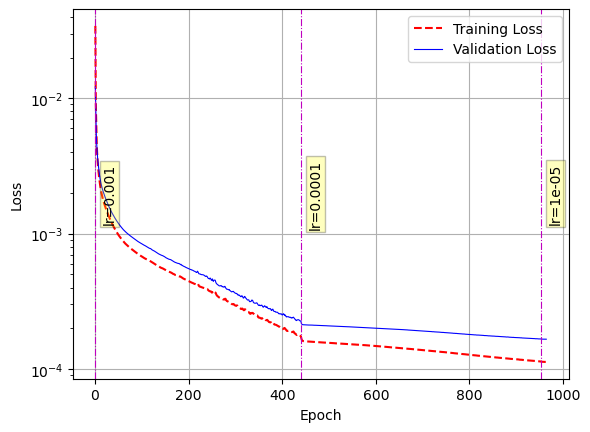

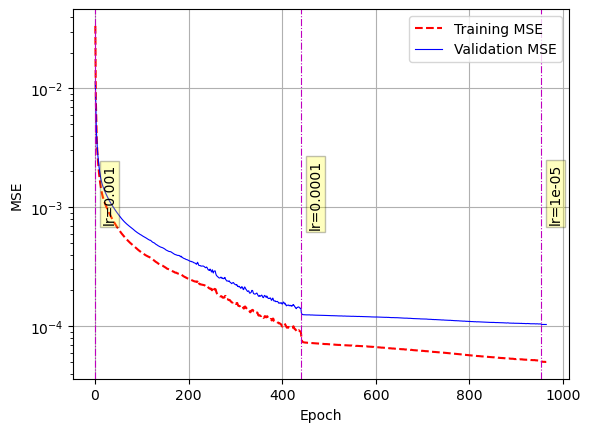

<Figure size 640x480 with 0 Axes>

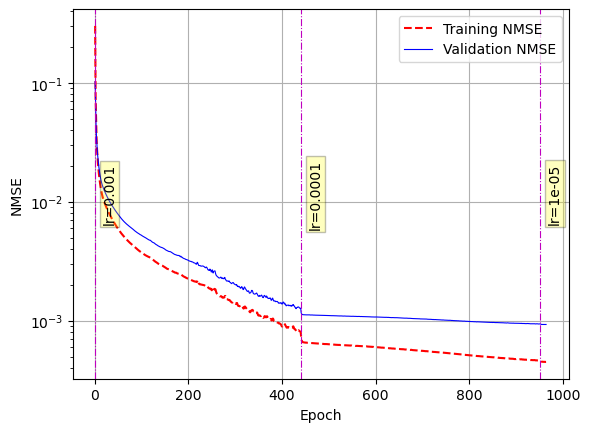

<Figure size 640x480 with 0 Axes>

In [37]:
# plotting losses
dir_name_plot = dir_name_rnn+dir_sep+'plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_rnn+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


fig, ax = plot_losses(
    training_loss=train_MSE_hist,
    val_loss=val_MSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training MSE', 'Validation MSE'],
    xlabel='Epoch',
    ylabel='MSE',
)
plt.savefig(dir_name_plot+'/MSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


fig, ax = plot_losses(
    training_loss=train_NMSE_hist,
    val_loss=val_NMSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training NMSE', 'Validation NMSE'],
    xlabel='Epoch',
    ylabel='NMSE',
)
plt.savefig(dir_name_plot+'/NMSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


data_idx : 52


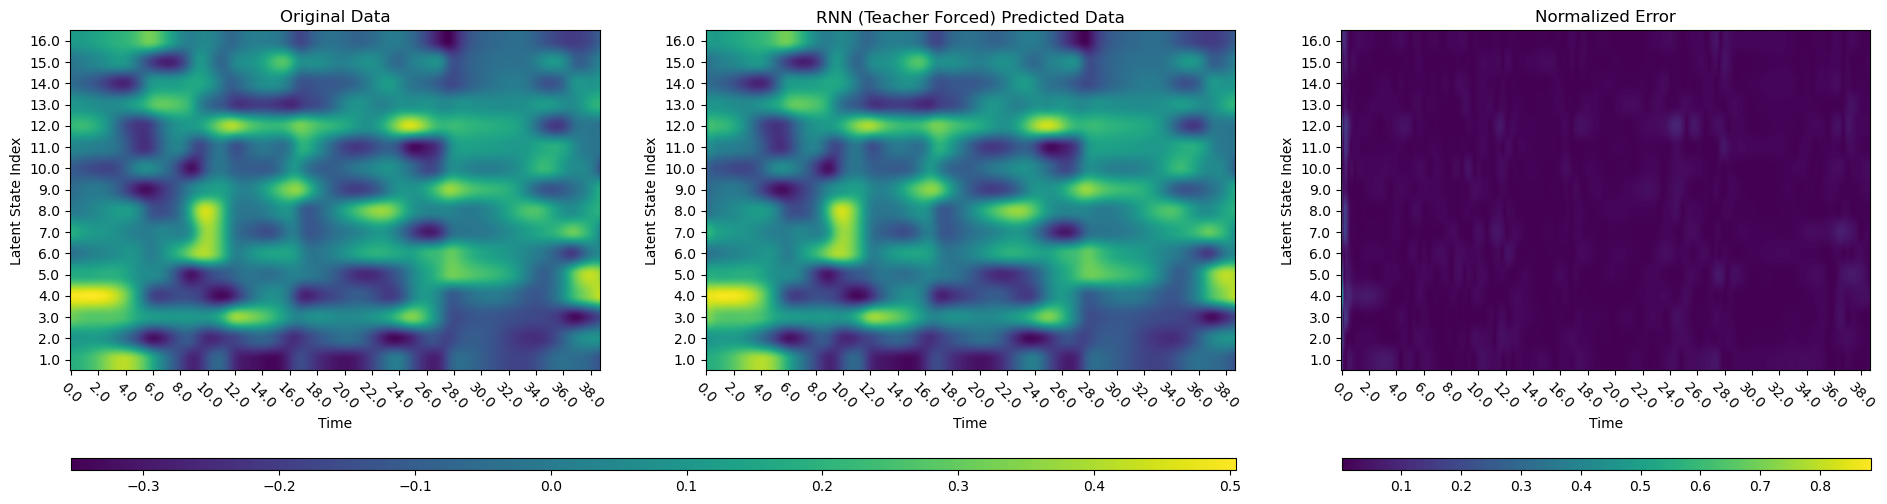

In [38]:
# data_type = 'training'
rnn_net.reset_states()
data_type = 'testing'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 3788
print('data_idx : {}'.format(data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])

plot_reconstructed_data_KS(
    [data_out.shape[0]],
    dir_name_ae,
    data_out,
    prediction[0], delta_t, 1+np.arange(0, data_out.shape[1]),
    save_figs=False,
    normalization_constant_arr=normalization_arr,
    xticks_snapto=2,
    num_yticks=data_out.shape[1],
    ylabel=r'Latent State Index',
    ax1_title=r'Original Data',
    ax2_title=r'RNN (Teacher Forced) Predicted Data')

In [39]:
prediction.shape, data_out.shape, rnn_net.stateful

((64, 387, 16), (387, 16), True)

In [40]:
def rescale_data(data, normalization_arr):
    '''
    data - [num_batches x num_timesteps x num_states]
    normalization_arr = [2 x num_states]
    '''
    new_data = data.copy()
    shape = new_data.shape
    for i in range(data.shape[-1]):
        new_data[:, i] -= normalization_arr[0, i]
        new_data[:, i] /= normalization_arr[1, i]

    return new_data

def norm_sq_time_average(data):
    data_norm_sq = np.zeros(shape=data.shape[0])
    for i in range(data.shape[1]):
        data_norm_sq[:] += data[:, i]**2
    # integrating using the trapezoidal rule
    norm_sq_time_avg = np.sum(data_norm_sq) - 0.5*(data_norm_sq[0]+data_norm_sq[-1])
    norm_sq_time_avg /= data_norm_sq.shape[0]
    return norm_sq_time_avg

def invert_normalization(data, normalization_arr):
    new_data = np.empty_like(data)
    shape = new_data.shape
    print(shape)
    for i in range(shape[-1]):
        if len(shape) == 2:
            new_data[:, i] = data[:, i]
            new_data[:, i] *= normalization_arr[1, i]
            new_data[:, i] += normalization_arr[0, i]
        elif len(shape) == 3:
            new_data[:, :, i] = data[:, :, i]
            new_data[:, :, i] *= normalization_arr[1, i]
            new_data[:, :, i] += normalization_arr[0, i]
    return new_data

case 1, data_idx : 26


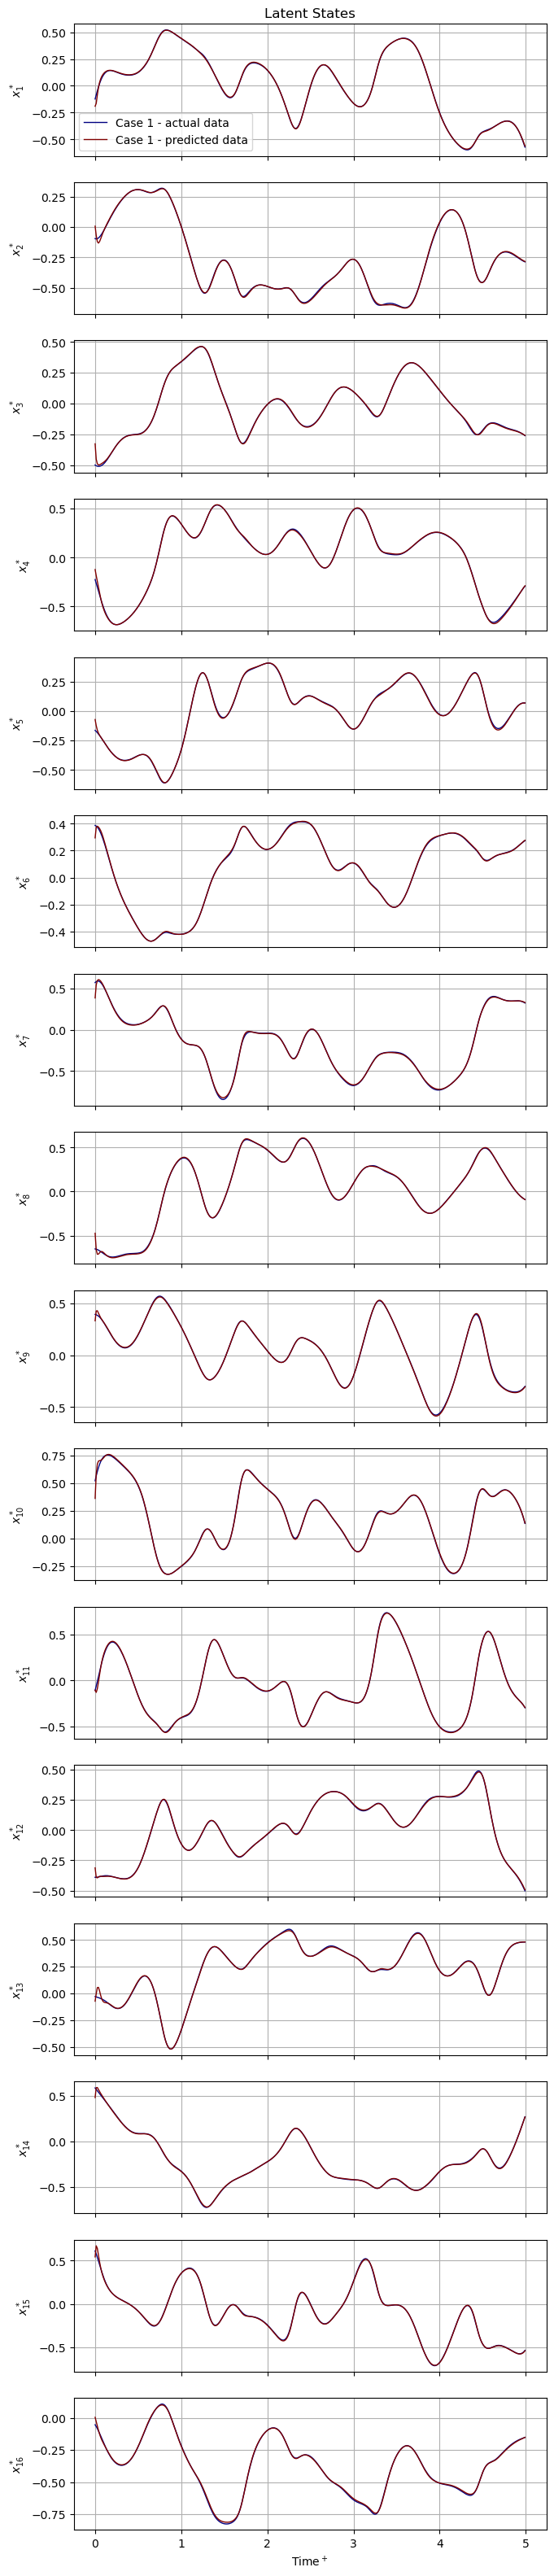


4.991497332033017


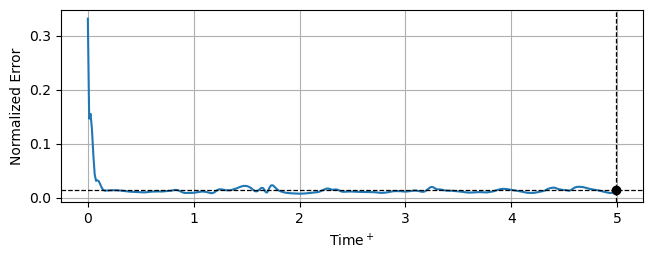

In [41]:
if rnn_net.stateful == True:
    for rnn_layer in rnn_net.rnn_list:
        rnn_layer.reset_states()


data_in = testing_data_rnn_input
data_out = testing_data_rnn_output

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 11269
for i in range(len(rnn_data_boundary_idx_arr)):
    if data_idx < rnn_data_boundary_idx_arr[i]:
        case_idx = i
        break
lyap_time = lyapunov_time_arr[case_idx]

print('case {}, data_idx : {}'.format(case_idx+1, data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]
# data_out = rescale_data(data_out, normalization_arr)
# data_out = invert_normalization(data_out, normalization_arr)

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])
# prediction = rnn_net(data_in[data_idx:data_idx+1, :, :], training=False)
# prediction = rnn_net.call(data_in[data_idx:data_idx+1, :, :], training=False)
# prediction = invert_normalization(prediction, normalization_arr)

n = 1
num_latent_states = data_out.shape[-1]
N = data_out.shape[0]

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = ['$x^*_{' +str(i)+'}$' for i in range(1, num_latent_states+1)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]
input_time = np.arange(0, N)*dt_rnn/lyap_time

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

mpl_ax_artist_list = []
for j in range(num_latent_states):
    for i in range(n):
        obj_in = ax[j].plot(input_time, data_out[:, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        obj_out = ax[j].plot(input_time, prediction[0, :, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
        mpl_ax_artist_list.append(obj_in[0])
        mpl_ax_artist_list.append(obj_out[0])
    ax[j].set_ylabel(ax_ylabels[j])
    # if xlim is not None:
    #     ax[j].set_xlim(xlim)
    # if ylim is not None:
    #     ax[j].set_ylim(ylim)
    ax[j].grid(True)
    ax[j].set_axisbelow(True)


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)
plt.show()
# plt.savefig('AR-GRU.png', dpi=300, bbox_inches='tight')
print('')

### Error and prediction horizon
# error = np.linalg.norm(data_out[:, :] - prediction[0, :, :], axis=1)
error = (data_out[:, :] - prediction[0, :, :])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.mean(np.divide(error, time_stddev**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0]
if predhor_idx.shape[0] == 0:
    predhor_idx = error.shape[0]-1
else:
    predhor_idx = predhor_idx[0]
ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)

plt.show()

In [42]:
normalization_arr

array([[-0.01334152, -0.00261581,  0.02099581,  0.03006471,  0.0282602 ,
         0.0071317 ,  0.01005646,  0.07305361,  0.03375387,  0.02128131,
        -0.01137792, -0.0153523 ,  0.02832958,  0.00729525,  0.06112615,
         0.03638883],
       [ 0.57221735,  0.5165402 ,  0.56873006,  0.5798129 ,  0.5267395 ,
         0.5602617 ,  0.5400706 ,  0.5276647 ,  0.55953586,  0.4929259 ,
         0.45475405,  0.5388398 ,  0.49729973,  0.5216943 ,  0.44654998,
         0.49534416]], dtype=float32)

# Autoregressive Mode

In [43]:
# s_in = testing_data_rnn_input.shape
# testing_data_rnn_input = testing_data_rnn_input.reshape((1, s_in[0]*s_in[1]) + s_in[2:])
# # testing_data_rnn_input = testing_data_rnn_input.reshape((s_in[0], s_in[1]) + s_in[2:])

# s_out = testing_data_rnn_output.shape
# testing_data_rnn_output = testing_data_rnn_output.reshape((1, s_out[0]*s_out[1]) + s_out[2:])
# # testing_data_rnn_output = testing_data_rnn_output.reshape((s_out[0], s_out[1]) + s_out[2:])

In [44]:
temp1 = np.empty_like(testing_data_rnn_input)
temp2 = np.empty_like(testing_data_rnn_output)

begin_idx = 0
testing_data_rolling_count = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    # num_samples = idx.shape[0]
    # num_train = int( (1-test_split-val_split)*num_samples )
    # num_val = int(val_split*num_samples)
    num_samples = num_samples_arr[i]
    num_test = num_test_arr[i]

    nbatches_test = num_test // batch_size

    for j in range(batch_size):
        temp1[testing_data_rolling_count + j*nbatches_test:testing_data_rolling_count + (j+1)*nbatches_test] = testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size]
        temp2[testing_data_rolling_count + j*nbatches_test:testing_data_rolling_count + (j+1)*nbatches_test] = testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size]

    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

In [45]:
testing_data_rnn_input_og = testing_data_rnn_input
testing_data_rnn_output_og = testing_data_rnn_output

testing_data_rnn_input = temp1
testing_data_rnn_output = temp2

In [46]:
s_in = testing_data_rnn_input.shape
testing_data_rnn_input = testing_data_rnn_input.reshape((1, s_in[0]*s_in[1]) + s_in[2:])
# testing_data_rnn_input = testing_data_rnn_input.reshape((s_in[0], s_in[1]) + s_in[2:])

s_out = testing_data_rnn_output.shape
testing_data_rnn_output = testing_data_rnn_output.reshape((1, s_out[0]*s_out[1]) + s_out[2:])
# testing_data_rnn_output = testing_data_rnn_output.reshape((s_out[0], s_out[1]) + s_out[2:])

In [47]:
T_sample_input_AR = 1*np.mean(lyapunov_time_arr)#50.1*dt_rnn
num_sample_input_AR = int((T_sample_input_AR+0.5*dt_rnn)//dt_rnn)

T_sample_output_AR = 10*np.mean(lyapunov_time_arr)
num_sample_output_AR = int((T_sample_output_AR+0.5*dt_rnn)//dt_rnn)

num_offset_AR = num_sample_input_AR
T_offset_AR = num_offset_AR*dt_rnn

batch_idx : 0
data_idx : 2454
data_.shape : (1, 850, 16)


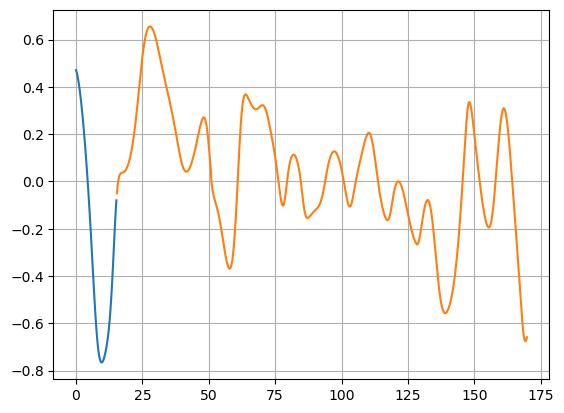

In [48]:
# data_to_consider = 'training'
data_to_consider = 'testing'

data_in = eval(data_to_consider+'_data_rnn_input')
data_out = eval(data_to_consider+'_data_rnn_output')

batch_idx = np.random.randint(low=0, high=data_in.shape[0])
maxpossible_num_runs = data_in.shape[1]-(num_sample_input_AR+num_sample_output_AR)

data_idx = np.random.randint(low=0, high=maxpossible_num_runs)

print('batch_idx : {}'.format(batch_idx))
print('data_idx : {}'.format(data_idx))
data_ = data_in[batch_idx:batch_idx+1, data_idx:data_idx+(num_sample_input_AR+num_sample_output_AR), :]
print('data_.shape :', data_.shape)

plt.plot(dt_rnn*np.arange(num_sample_input_AR), data_[0, 0:num_sample_input_AR, 0])
plt.plot(dt_rnn*num_sample_input_AR+dt_rnn*np.arange(num_sample_output_AR), data_[0, num_sample_input_AR:, 0])
plt.grid(True)
plt.show()

In [49]:
prediction_lst = []

for layer in rnn_net.rnn_list:
    if layer.stateful == True:
        layer.reset_states()

    if data_.shape[0] != batch_size:
        data_ = np.tile(data_, (batch_size, 1, 1))
input_preds = np.array(rnn_net(data_[:, 0:num_sample_input_AR, :]))

prediction_lst.append(input_preds[:, -2:-1, :])

for i in range(1, num_sample_output_AR):
    data_in_i = np.array(prediction_lst[-1])
    output = np.array(rnn_net(data_in_i, training=False))
    prediction_lst.append(output[:, 0:1, :])

In [50]:
prediction_lst = np.stack(prediction_lst)
prediction_lst = np.squeeze(prediction_lst)
if rnn_net.stateful == True:
    prediction_lst = np.transpose(prediction_lst, [1, 0, 2])
# print(np.squeeze(prediction_lst).shape)
# print(np.transpose(prediction_lst, [1, 0, 2]).shape)

print('input_preds.shape : {}'.format(input_preds.shape))
print('prediction_lst.shape : {}'.format(prediction_lst.shape))

input_preds.shape : (64, 77, 16)
prediction_lst.shape : (64, 773, 16)


In [51]:
data_ = data_[0:1]
if rnn_net.stateful == True:
    prediction_lst = prediction_lst[0]
input_preds = input_preds[0]

0.6853610326366578


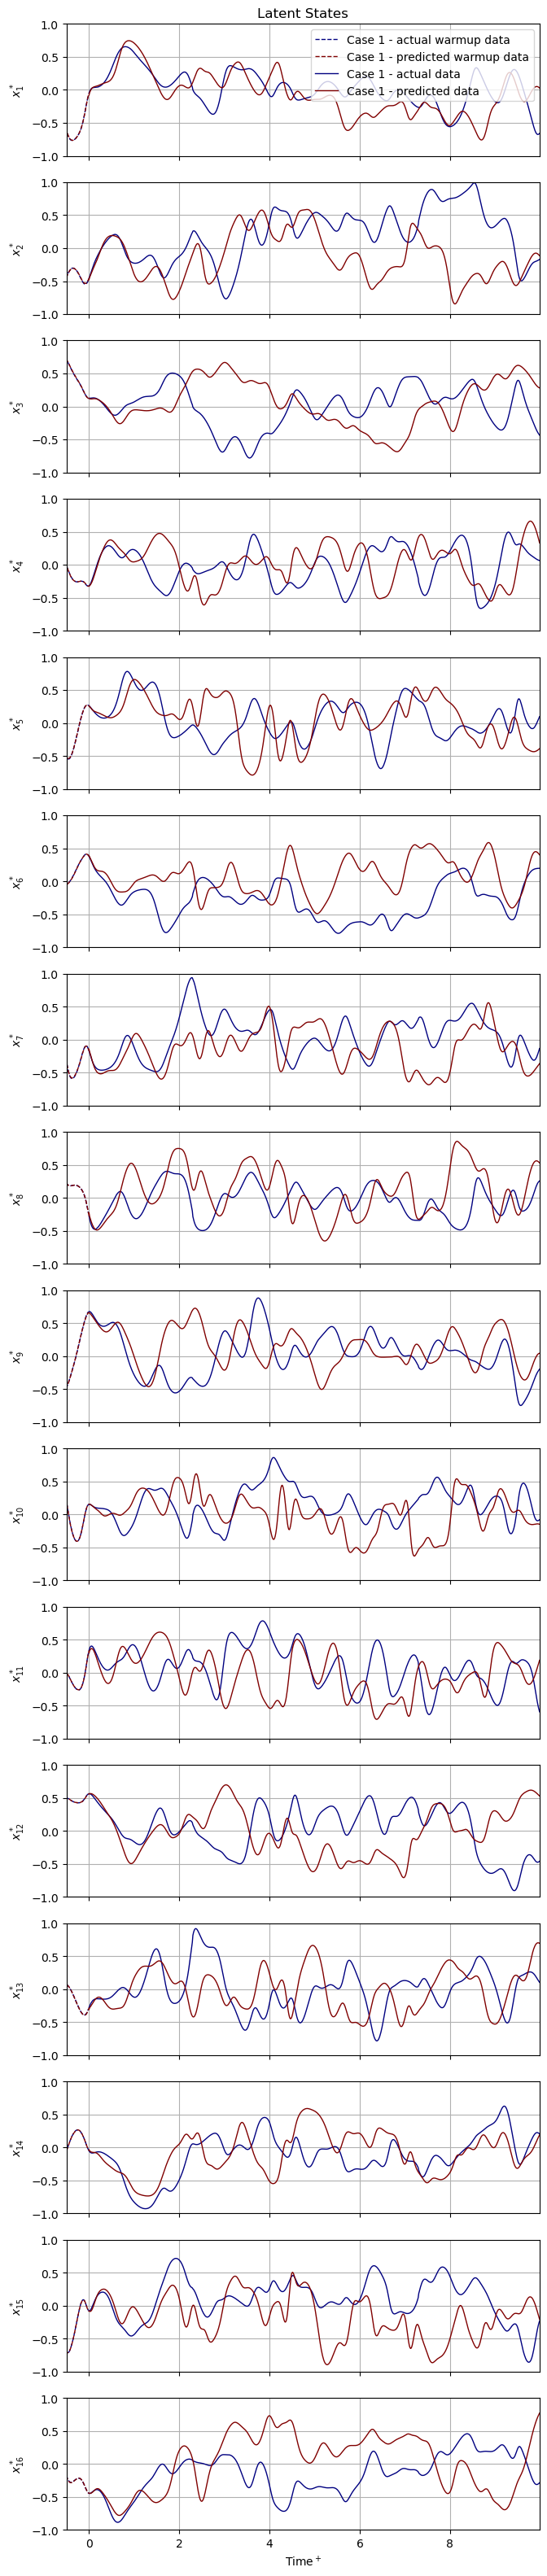

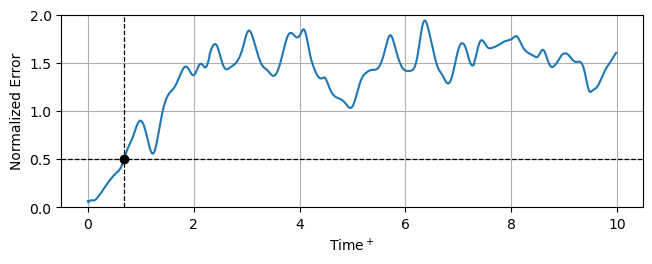

In [52]:
lyap_time = np.mean(lyapunov_time_arr)

n = 1
num_latent_states = input_preds.shape[-1]
N = num_sample_output_AR#num_output_timesteps

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = [r'$x^*_{'+str(i+1)+'}$' for i in range(num_latent_states)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

time_arr_warmup1 = (np.arange(num_sample_input_AR) - num_sample_input_AR)*dt_rnn
time_arr_warmup2 = time_arr_warmup1 + dt_rnn

time_arr_warmup1 /= lyap_time
time_arr_warmup2 /= lyap_time

input_time = time_arr_warmup2[-1]+np.arange(N, dtype=float)*dt_rnn/lyap_time

for j in range(num_latent_states):
    for i in range(n):
        ax[j].plot(time_arr_warmup1, data_[0, 0:num_sample_input_AR, j], linestyle='--', linewidth=1, color=colors[2*i], label='Case {} - actual warmup data'.format(i+1))
        ax[j].plot(time_arr_warmup2, input_preds[:, j], linestyle='--', linewidth=1, color=colors[2*i+1], label='Case {} - predicted warmup data'.format(i+1))
        ax[j].plot(input_time, data_[0, num_sample_input_AR:num_sample_input_AR+N, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        ax[j].plot(input_time, prediction_lst[:, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
    ax[j].set_ylabel(ax_ylabels[j])
    ax[j].grid(True)
    ax[j].set_axisbelow(True)
    ax[j].set_ylim([-1, 1])
    ax[j].set_xlim([input_time[0] - 0.5, input_time[-1]])


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)


### error computation
error = (data_[0, num_sample_input_AR:num_sample_input_AR+N, :] - prediction_lst[:, :])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.mean(np.divide(error, time_stddev**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0]
if predhor_idx.shape[0] == 0:
    predhor_idx = error.shape[0]-1
else:
    predhor_idx = predhor_idx[0]
ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.set_ylim([0, 2])

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)

In [53]:
# sp = np.array([var.numpy() for var in rnn_net.scalar_multiplier_pre_list])
# print(sp)
# sum_ = np.sum(np.exp(sp))
# print(np.exp(sp)/sum_)

In [55]:
rnn_net.dense[-1].weights

[<tf.Variable 'rnn_gru/time_distributed_1/individual_weights:0' shape=(16,) dtype=float32, numpy=
 array([1.4615757, 1.5955049, 1.409426 , 1.2706935, 1.4718949, 1.5315964,
        1.5131507, 1.5734779, 1.5054044, 1.3448894, 1.564812 , 1.1393831,
        1.4927253, 1.1648257, 1.4933457, 1.5514784], dtype=float32)>]

In [56]:
if use_trainable_weights_with_reslayers == True:
    for i in range(rnn_net.num_skip_connections):
        print('reslayer_factor_{} : {}'.format(i, rnn_net.reslayer_factor[i]))

reslayer_factor_0 : <tf.Variable 'reslayer_weight_0:0' shape=() dtype=float32, numpy=0.97818303>
reslayer_factor_1 : <tf.Variable 'reslayer_weight_1:0' shape=() dtype=float32, numpy=0.9787268>
